In [1]:
from datetime import timedelta
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append('../src/')

In [3]:
# set plotting params
import matplotlib as mpl
import plots
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.reload_library()
rcparams = plots.stdrcparams()
mpl.rcParams.update(rcparams)

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

In [5]:
mimic_dir = r'../data/mimic_iv'
derived_dir = r'../data/mimiciv_derived'
included_dir = r'../data/mimiciv_included'
curated_dir = r'../data/curated'

## ICU daily

In [6]:
icus = pd.read_csv(os.path.join(included_dir, 'icus.csv'), index_col=0).reset_index(drop=True)

In [7]:
icu_stays = icus[['subject_id', 'hadm_id', 'stay_id', 'icu_intime', 'icu_outtime', 'los_icu', 'icustay_seq']]

In [8]:
icu_stays = icu_stays.assign(icu_start_day=pd.to_datetime(icu_stays.icu_intime).dt.date)
icu_stays = icu_stays.assign(icu_end_day=pd.to_datetime(icu_stays.icu_outtime).dt.date)

In [9]:
icu_stays = icu_stays.assign(days=icu_stays.apply(lambda row: list(range((row['icu_end_day']-row['icu_start_day']).days+1)), axis=1))

In [10]:
tmp = icu_stays[['subject_id', 'icustay_seq']].drop_duplicates().groupby('subject_id').size().to_frame('nc')

Text(0, 0.5, 'Count')

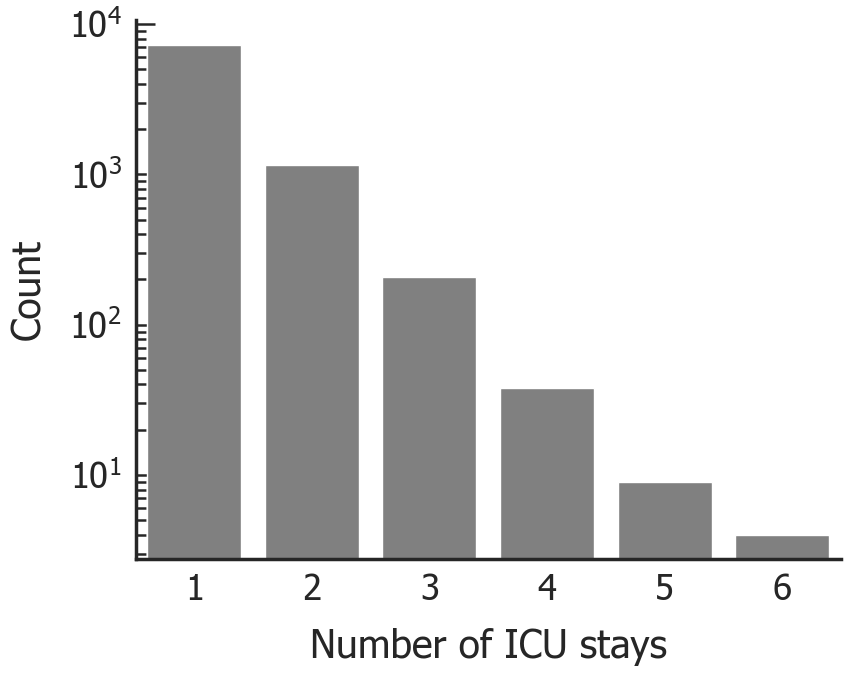

In [11]:
fig, ax = plt.subplots(figsize=plots.stdfigsize(nx=1, ny=1))
sns.countplot(data=tmp,x='nc', ax=ax, color='Gray')
ax.set_yscale('log')

ax.set_xlabel('Number of ICU stays')
ax.set_ylabel('Count')

# plt.savefig("../plots/mimiciv/nICU_240307.png", dpi=150, transparent=True, bbox_inches='tight')

In [12]:
icus_daily = icu_stays.explode('days', ignore_index=True)

In [13]:
icus_daily = icus_daily.assign(icu_date=icus_daily.apply(lambda row: row['icu_start_day']+timedelta(days=row['days']), axis=1))

In [14]:
icus_daily = icus_daily.rename(columns={'days':'icu_day'})

## discharge

In [15]:
admissions = pd.read_csv(os.path.join(mimic_dir, 'hosp', 'admissions.csv.gz'))

In [16]:
adm = admissions.merge(icus[['subject_id', 'hadm_id']].drop_duplicates())

In [17]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val) if pct>5 else ''
        return my_format

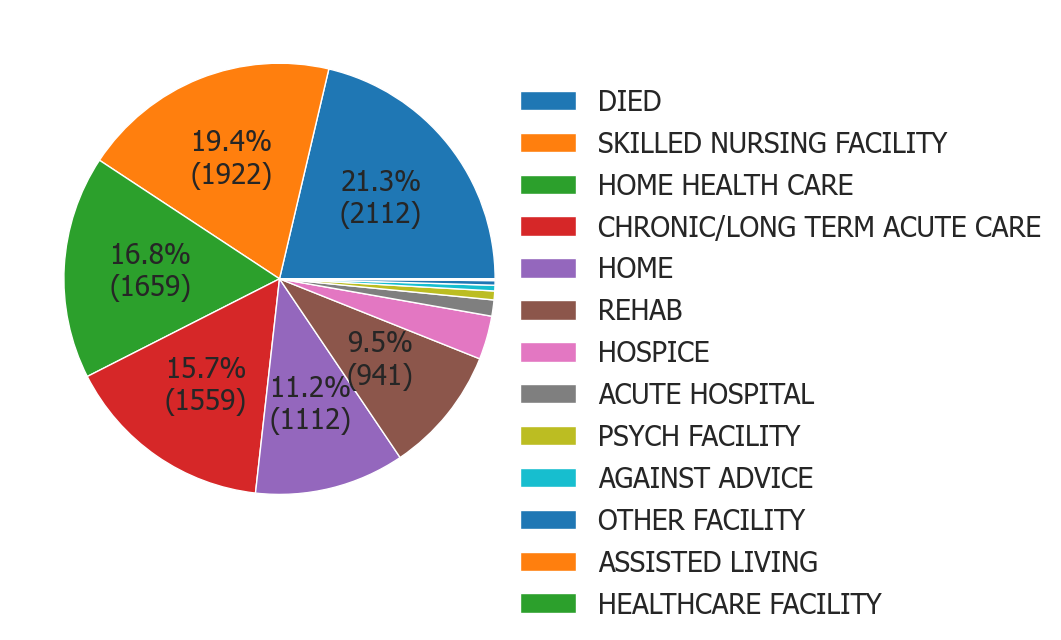

In [18]:
tmp = adm.discharge_location.value_counts()
fig, ax = plt.subplots(figsize=plots.stdfigsize(nx=1, ny=1))

wedges, texts, autotexts = ax.pie(tmp, labels = tmp.index, autopct=autopct_format(tmp), textprops={'fontsize': 20}, labeldistance=None)

ax.legend(wedges, tmp.index,
          title='',
          loc="best",
          bbox_to_anchor=(0.9, 0.9), 
          frameon=False)

# plt.savefig("../plots/mimiciv/discharge_location_240307.png", dpi=150, transparent=True, bbox_inches='tight')

In [19]:
adm = adm.assign(discharge='Other')
adm.loc[adm.discharge_location.isna(), 'discharge'] = np.nan
adm.loc[adm.discharge_location=='HOME', 'discharge'] = 'Recovered'
adm.loc[adm.discharge_location=='DIED', 'discharge'] = 'Died'

Text(0, 0.5, 'Length of final ICU stay')

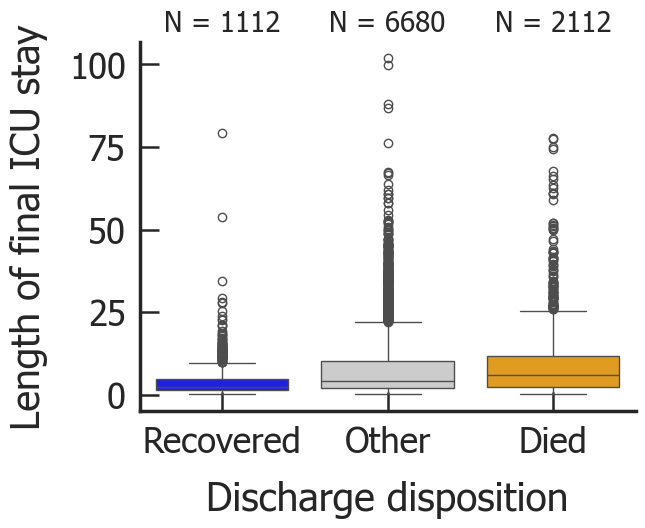

In [20]:
df = icu_stays.sort_values('icustay_seq').drop_duplicates(subset=['subject_id', 'hadm_id'], keep='last').merge(adm, how='left')

cnts = df.discharge.value_counts()
my_pal = {"Recovered": "blue", "Other": "0.8", "Died":"orange"}

f1c, ax = plt.subplots()

sns.boxplot(data=df, x="discharge", y="los_icu", hue="discharge", ax=ax, order=['Recovered', 'Other', 'Died'], palette=my_pal, legend=False)

ax.text(2, 110, f'N = {cnts["Died"]}', fontsize=20, ha='center')
ax.text(0, 110, f'N = {cnts["Recovered"]}', fontsize=20, ha='center')
ax.text(1, 110, f'N = {cnts["Other"]}', fontsize=20, ha='center')
ax.set_xlabel("Discharge disposition")
ax.set_ylabel("Length of final ICU stay")

# plt.savefig("../plots/mimiciv/F1c_240307.png", dpi=150, transparent=True, bbox_inches='tight')

In [21]:
icu_stays = icu_stays.assign(icu_outtime=pd.to_datetime(icu_stays.icu_outtime))

In [22]:
adm = adm.assign(dischtime=pd.to_datetime(adm.dischtime))

In [23]:
df = icu_stays.groupby(['subject_id', 'hadm_id']).icu_outtime.max().reset_index().merge(adm)

In [24]:
df['Itv'] = (df.dischtime-df.icu_outtime).dt.total_seconds()/3600/24

In [25]:
edps = df[['subject_id', 'hadm_id', 'icu_outtime', 'dischtime', 'discharge_location', 'discharge', 'hospital_expire_flag', 'Itv']]

Text(0, 0.5, 'Time gap (days)')

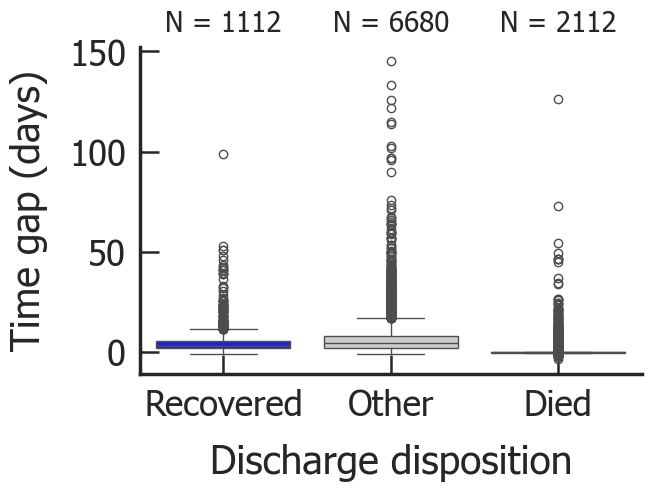

In [26]:
f1g, ax = plt.subplots(constrained_layout=True)

cnts = df.discharge.value_counts()
sns.boxplot(data=df, x="discharge", y="Itv", hue="discharge", ax=ax, order=['Recovered', 'Other', 'Died'], palette=my_pal, legend=False)

ax.text(2, 160, f'N = {cnts["Died"]}', fontsize=20, ha='center')
ax.text(0, 160, f'N = {cnts["Recovered"]}', fontsize=20, ha='center')
ax.text(1, 160, f'N = {cnts["Other"]}', fontsize=20, ha='center')
ax.set_xlabel("Discharge disposition")
ax.set_ylabel("Time gap (days)")
# ax.set_title("ICU discharge to hospital discharge")
# ax.set_ylim(-2, 45)

# plt.savefig("../plots/mimiciv/F1d_240307.png", dpi=150, transparent=True, bbox_inches='tight')

## pneumonia

In [27]:
icd_pneu = pd.read_csv(os.path.join(included_dir, 'icd_pneu.csv'), index_col=0).reset_index(drop=True)

In [28]:
icd_pneu = icd_pneu.assign(cat='Other')
icd_pneu.loc[icd_pneu.long_title=='Pneumonia, organism unspecified', 'cat'] = 'Indeterminate'
icd_pneu.loc[icd_pneu.long_title.str.contains('unspecified organism', case=False), 'cat'] = 'Indeterminate'
icd_pneu.loc[icd_pneu.long_title=='Ventilator associated pneumonia', 'cat'] = 'VAP'
icd_pneu.loc[icd_pneu.long_title.str.contains('bacteri', case=False), 'cat'] = 'Bacterial'
icd_pneu.loc[icd_pneu.long_title=='Pneumonia due to Pseudomonas', 'cat'] = 'Bacterial'
icd_pneu.loc[icd_pneu.long_title.str.contains('Staphylococcus', case=False), 'cat'] = 'Bacterial'
icd_pneu.loc[icd_pneu.long_title=='Pneumonia due to Klebsiella pneumoniae', 'cat'] = 'Bacterial'
icd_pneu.loc[icd_pneu.long_title.str.contains('Streptococcus', case=False), 'cat'] = 'Bacterial'
icd_pneu.loc[icd_pneu.long_title.str.contains('escherichia', case=False), 'cat'] = 'Bacterial'
icd_pneu.loc[icd_pneu.long_title.str.contains('Influenz', case=False), 'cat'] = 'Viral'
icd_pneu.loc[icd_pneu.long_title.str.contains('vir', case=False), 'cat'] = 'Viral'

In [29]:
tmp

discharge_location
DIED                            2112
SKILLED NURSING FACILITY        1922
HOME HEALTH CARE                1659
CHRONIC/LONG TERM ACUTE CARE    1559
HOME                            1112
REHAB                            941
HOSPICE                          324
ACUTE HOSPITAL                   120
PSYCH FACILITY                    66
AGAINST ADVICE                    42
OTHER FACILITY                    34
ASSISTED LIVING                   11
HEALTHCARE FACILITY                2
Name: count, dtype: int64

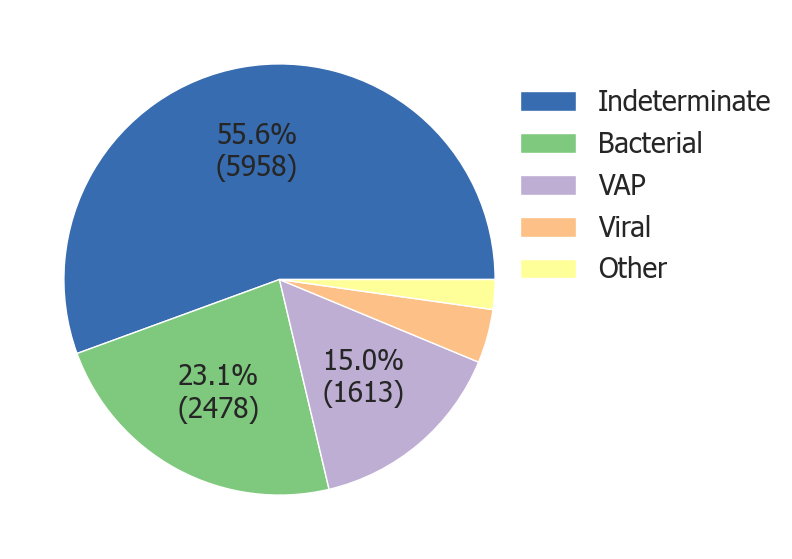

In [30]:
tmp = icd_pneu.cat.value_counts()
fig, ax = plt.subplots(figsize=plots.stdfigsize(nx=1, ny=1))

wedges, texts, autotexts = ax.pie(tmp, labels = tmp.index, autopct=autopct_format(tmp), \
textprops={'fontsize': 20}, labeldistance=None, \
colors=['#386cb0', '#7fc97f','#beaed4','#fdc086','#ffff99'])

ax.legend(wedges, tmp.index,
          title='',
          loc="best",
          bbox_to_anchor=(0.9, 0.9), 
          frameon=False)

# plt.savefig("../plots/mimiciv/icd_longtitle_240307.png", dpi=150, transparent=True, bbox_inches='tight')

In [31]:
f = icd_pneu.long_title.str.contains('unspecified organism', case=False)
icd_pneu[f].long_title.unique()

array(['Pneumonia, unspecified organism',
       'Lobar pneumonia, unspecified organism',
       'Other pneumonia, unspecified organism',
       'Bronchopneumonia, unspecified organism'], dtype=object)

In [32]:
f = icd_pneu.long_title.value_counts(normalize=True)>=0.001
f2 = icd_pneu.cat=='Other'
icd_pneu[f2].long_title.value_counts(normalize=True)[f]

long_title
Pneumonia in aspergillosis                   0.200837
Postprocedural aspiration pneumonia          0.184100
Abscess of lung with pneumonia               0.108787
Pneumonia due to Legionnaires' disease       0.096234
Bronchopneumonia, organism unspecified       0.087866
Pneumonia in other systemic mycoses          0.066946
Pneumonia due to other specified organism    0.050209
Pneumonia due to other streptococci          0.046025
Name: proportion, dtype: float64

In [33]:
icd_pneu.long_title.unique()

array(['Pneumonia, organism unspecified',
       'Pneumonia, unspecified organism',
       'Methicillin susceptible pneumonia due to Staphylococcus aureus',
       'Ventilator associated pneumonia',
       'Bacterial pneumonia, unspecified',
       'Pneumonia due to Klebsiella pneumoniae',
       'Pneumonia due to Methicillin susceptible Staphylococcus aureus',
       'Methicillin resistant pneumonia due to Staphylococcus aureus',
       'Pneumonia due to respiratory syncytial virus',
       'Pneumonia in other systemic mycoses',
       'Pneumonia in aspergillosis', 'Unspecified bacterial pneumonia',
       'Pneumonia due to other Streptococcus',
       'Pneumococcal pneumonia [Streptococcus pneumoniae pneumonia]',
       'Pneumonia due to other Gram-negative bacteria',
       'Pneumonia due to Pseudomonas',
       'Lobar pneumonia, unspecified organism',
       'Parainfluenza virus pneumonia',
       'Pneumonia due to other specified bacteria',
       'Pneumonia due to Escherichia col

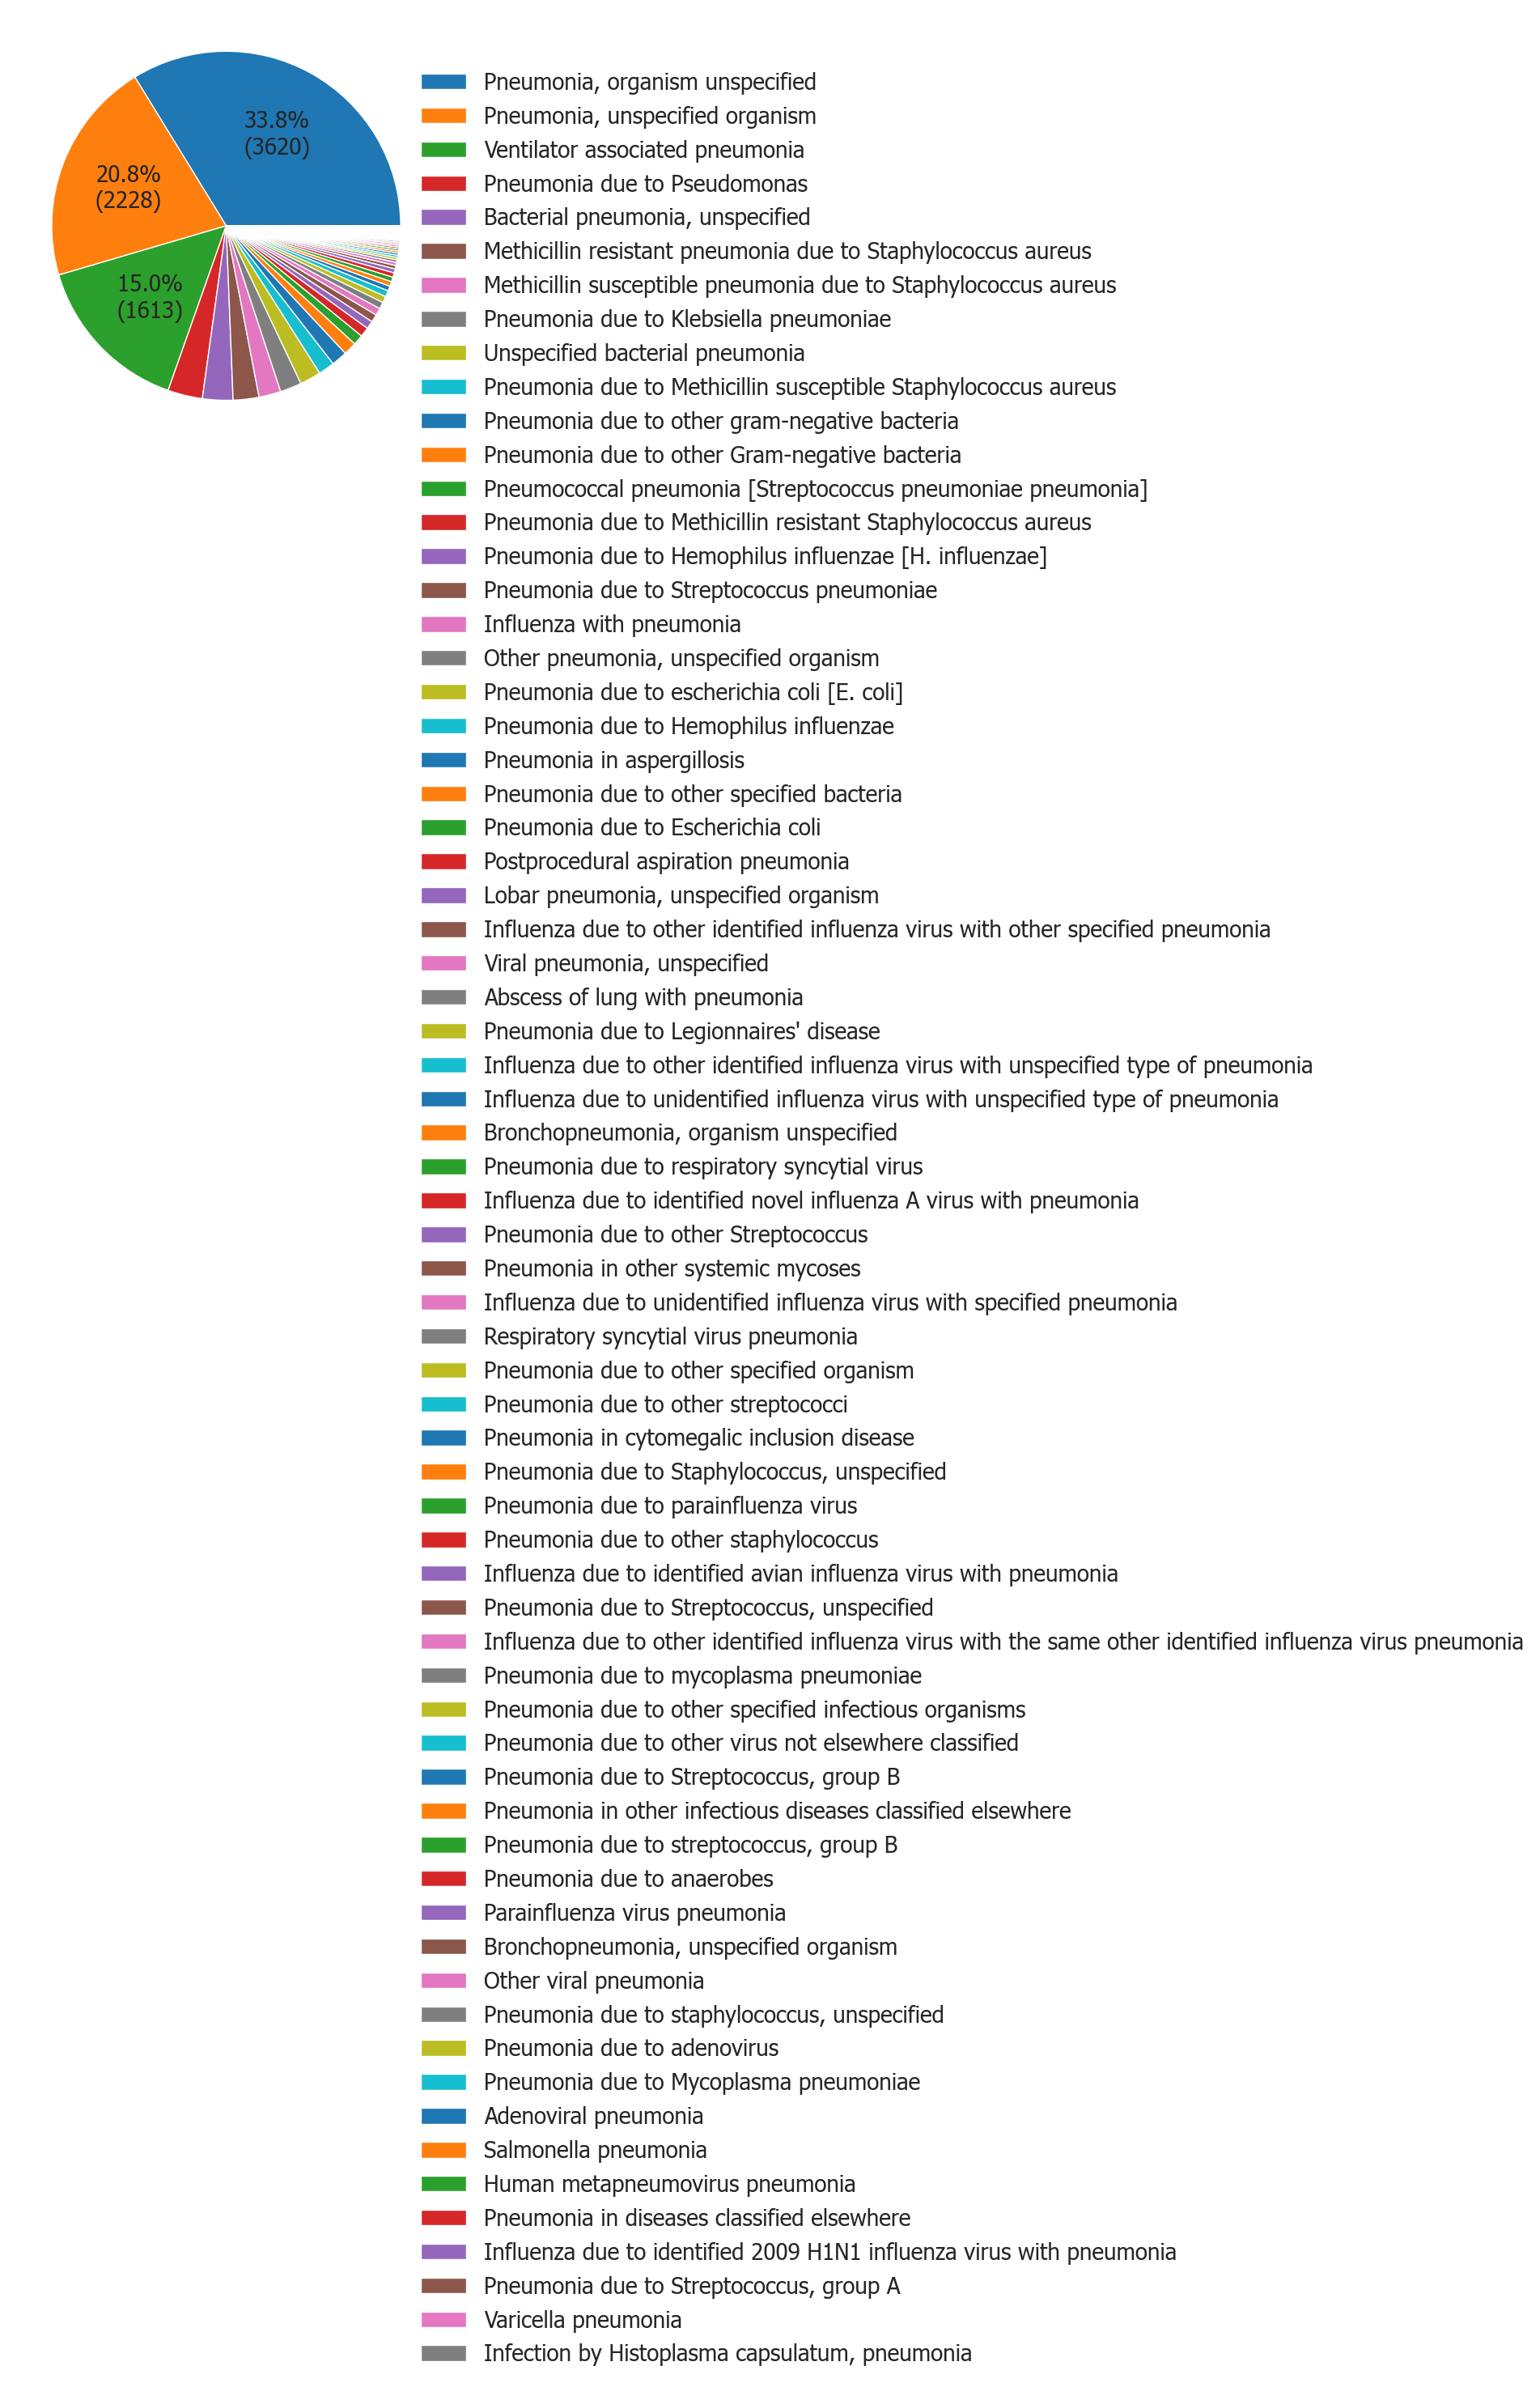

In [34]:
tmp = icd_pneu.long_title.value_counts()
fig, ax = plt.subplots(figsize=plots.stdfigsize(nx=1, ny=1))

wedges, texts, autotexts = ax.pie(tmp, labels = tmp.index, autopct=autopct_format(tmp), textprops={'fontsize': 20}, labeldistance=None)

ax.legend(wedges, tmp.index,
          title='',
          loc="best",
          bbox_to_anchor=(0.9, 0.9), 
          frameon=False)

# plt.savefig("../plots/mimiciv/icd_longtitle_240307.png", dpi=150, transparent=True, bbox_inches='tight')

## sofa

In [35]:
sofa = pd.read_csv(os.path.join(derived_dir, 'sofa.csv.gz'))

In [36]:
gcs = pd.read_csv(os.path.join(derived_dir, 'gcs.csv.gz'))

In [37]:
f = gcs.stay_id.isin(icu_stays.stay_id)
gcs = gcs[f]

In [38]:
gcs = gcs.assign(icu_date=pd.to_datetime(gcs.charttime).dt.date)

In [39]:
gcs = gcs[['stay_id', 'icu_date', 'gcs_motor', 'gcs_verbal', 'gcs_eyes']].drop_duplicates()

In [40]:
gcs = gcs.groupby(['stay_id', 'icu_date']).agg('max').reset_index()

In [41]:
f = sofa.stay_id.isin(icu_stays.stay_id)
sofa = sofa[f]

In [42]:
sofa = sofa.assign(icu_date=pd.to_datetime(sofa.starttime).dt.date)

In [43]:
sofa = sofa.filter(regex='stay_id|icu_date|24hours|24hr').reset_index(drop=True)

In [44]:
sofa = sofa.drop_duplicates()

In [45]:
sofa = sofa.groupby(['stay_id', 'icu_date']).agg('max').reset_index()

In [46]:
sofa = sofa.merge(gcs, how='left')

In [47]:
data = icus_daily.merge(sofa, how='left')

In [48]:
dsc_features = sofa.columns[2:]

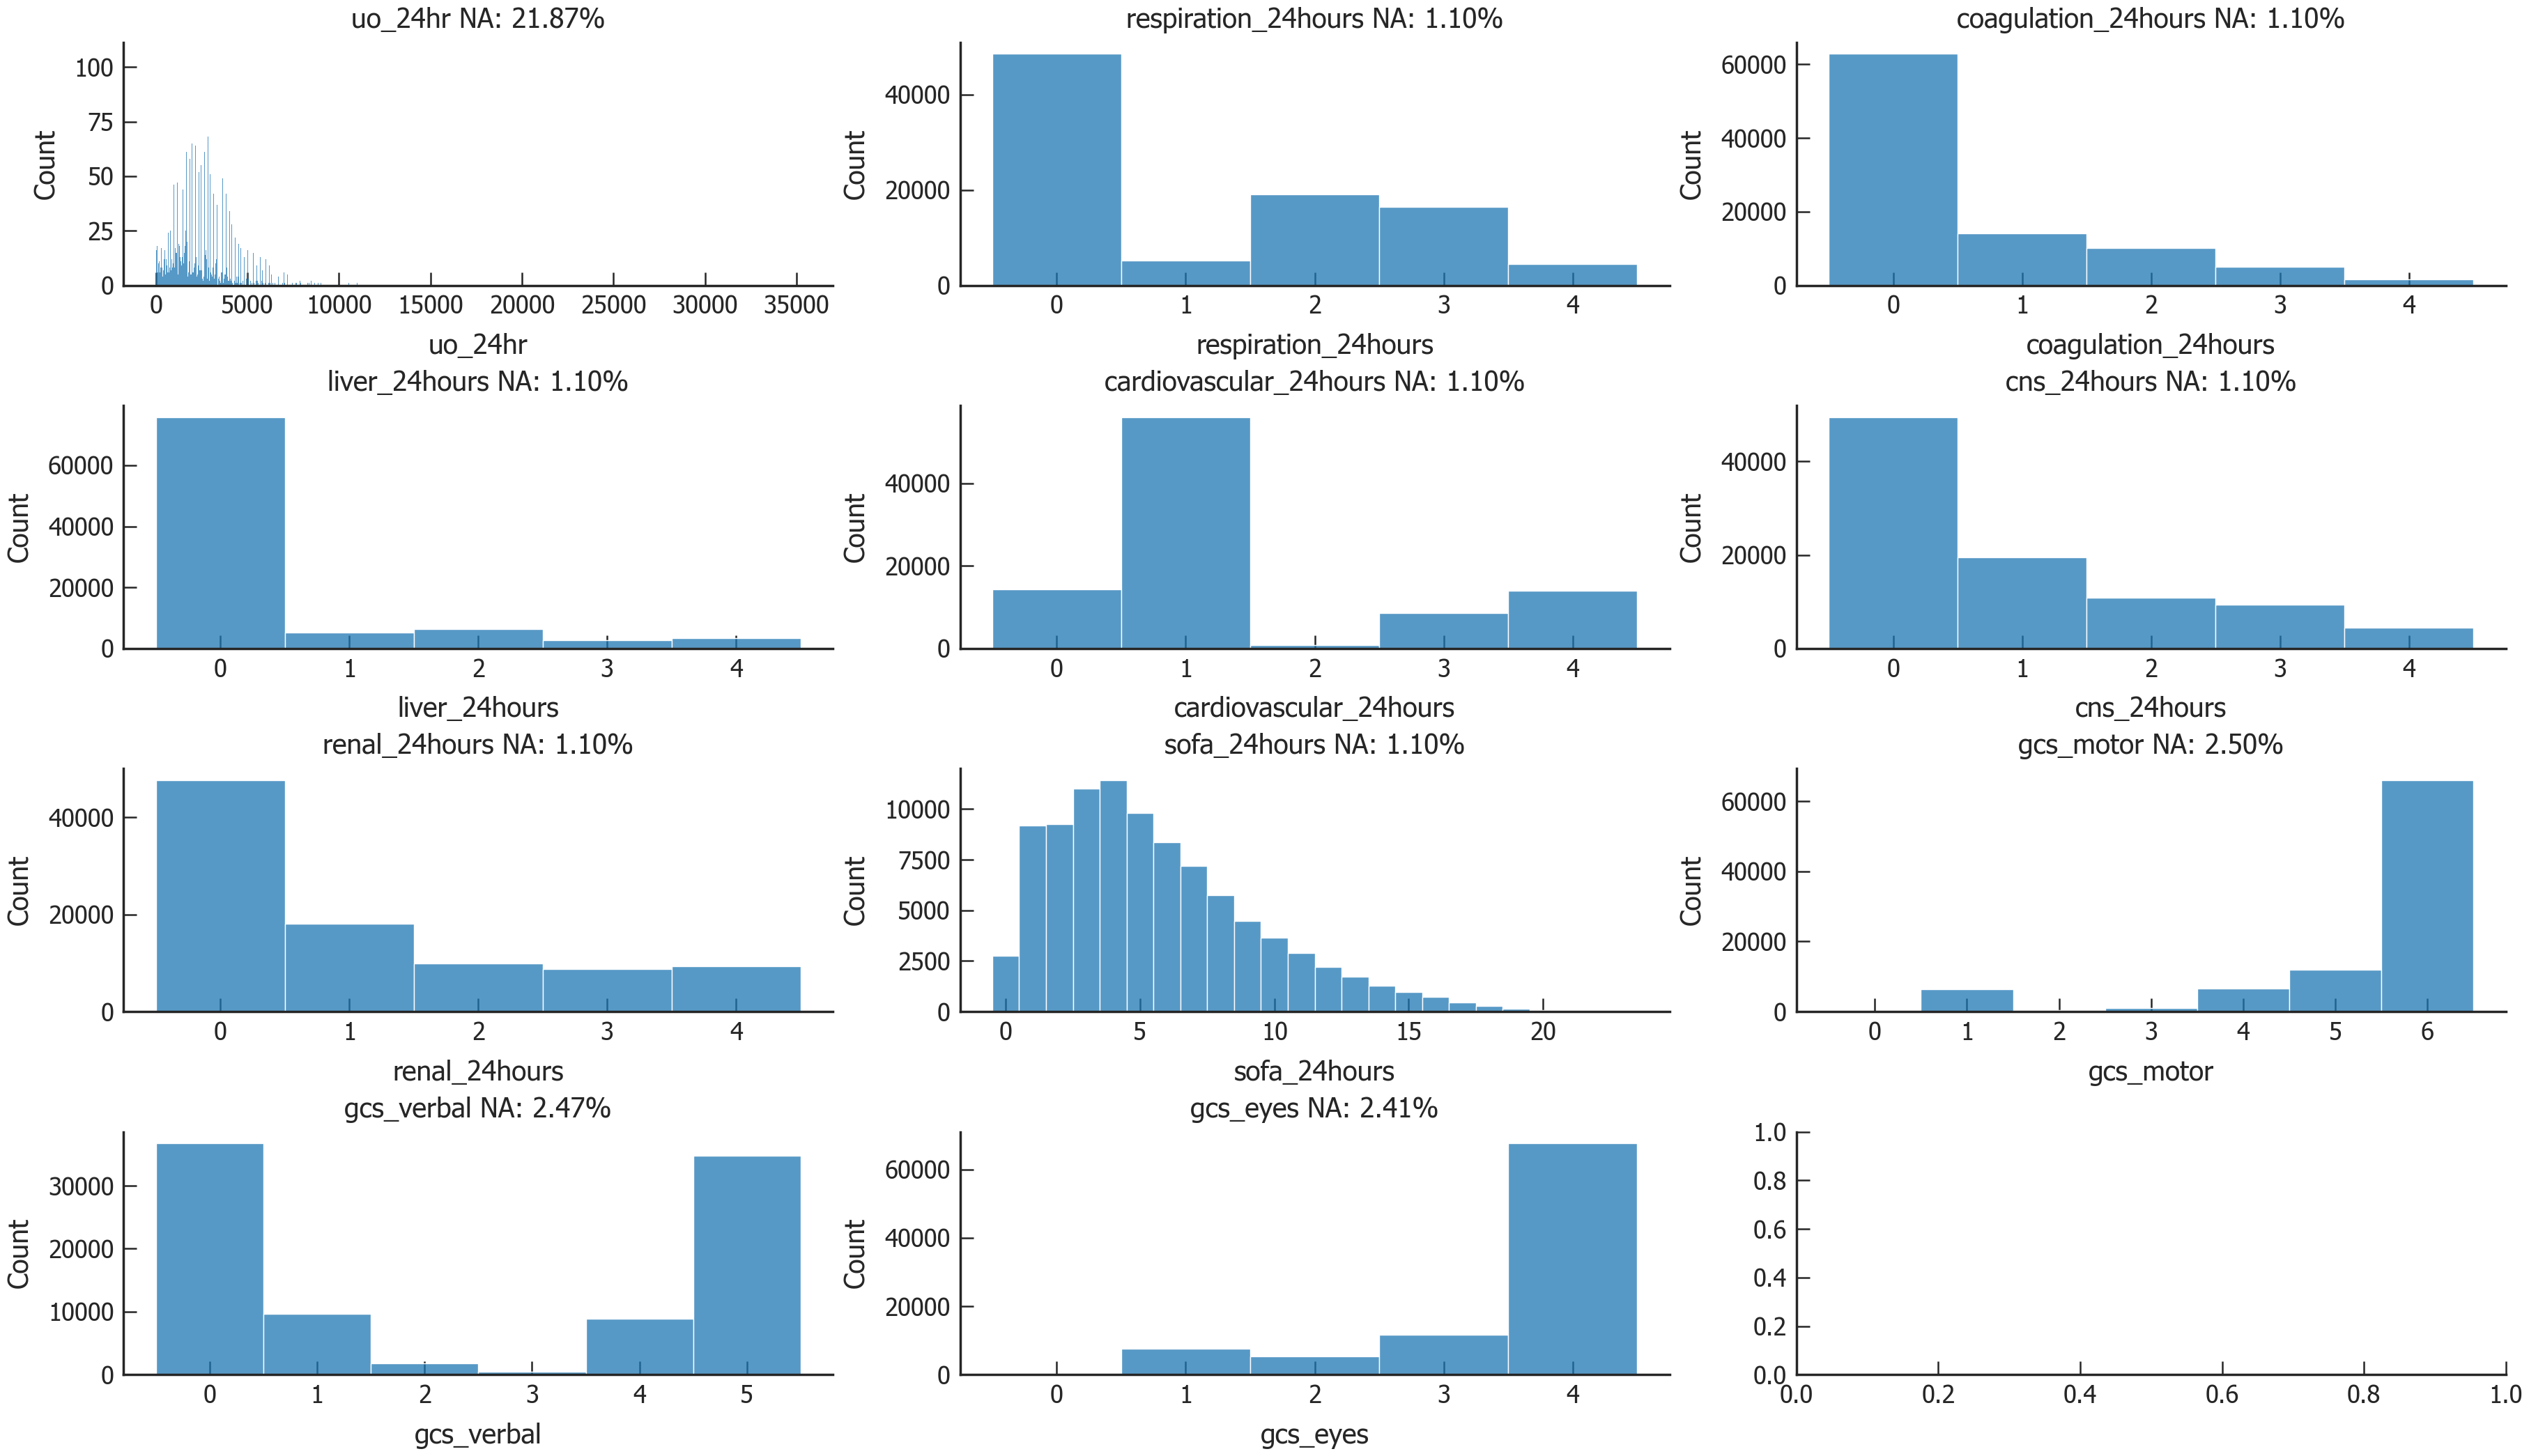

In [49]:
cols = np.pad(np.array(dsc_features, dtype=object), (0, 12-len(dsc_features)), constant_values=np.nan).reshape(4, 3)
fig, axes = plt.subplots(
    nrows=cols.shape[0], 
    ncols=cols.shape[1], 
    figsize=plots.stdfigsize(nx=cols.shape[0], ny=cols.shape[1]), 
    # gridspec_kw={"wspace": 0.4, "hspace": 0.5}
)
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        column = cols[row, col]
        if isinstance(column, str):
            bins = np.arange(0, data[column].max() + 1.5) - 0.5
            tmp = sns.histplot(data[column], ax=axes[row, col], kde=False, bins=bins)
            axes[row, col].set_title(column+f' NA: {(data[column].isna().sum()/data.shape[0]):.2%}')
plt.tight_layout()
# plt.savefig("../plots/mimiciv/sofSubs_240307.png", dpi=150, transparent=True, bbox_inches='tight')

## dmos

In [50]:
age = pd.read_csv(os.path.join(derived_dir, 'age.csv.gz'))

In [51]:
data = data.merge(age[['subject_id', 'hadm_id', 'age']].drop_duplicates(), how='left')

In [52]:
first_day_weight = pd.read_csv(os.path.join(derived_dir, 'first_day_weight.csv.gz'))

In [53]:
weight = first_day_weight[['subject_id', 'stay_id', 'weight']].drop_duplicates()

In [54]:
height = pd.read_csv(os.path.join(derived_dir, 'height.csv.gz'))

In [55]:
height[['subject_id', 'stay_id', 'height']].drop_duplicates().stay_id.duplicated().sum()

0

In [56]:
data = data.merge(height[['subject_id', 'stay_id', 'height']].drop_duplicates(), how='left')

In [57]:
weight.stay_id.duplicated().sum()

0

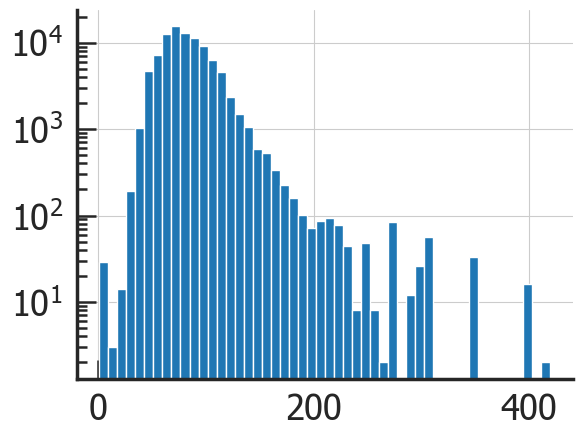

In [58]:
data.merge(weight).weight.hist(bins=50)
plt.yscale('log')

In [59]:
weight.loc[weight.weight<30, 'weight'] = np.nan # outlier

In [60]:
data = data.merge(weight)

## vitals

In [61]:
vitalsign = pd.read_csv(os.path.join(derived_dir, 'vitalsign.csv.gz'))

In [62]:
f = vitalsign.stay_id.isin(icu_stays.stay_id)
vitalsign = vitalsign[f]

In [63]:
vitalsign = vitalsign.assign(icu_date=pd.to_datetime(vitalsign.charttime).dt.date)

In [64]:
vitals = vitalsign.drop(columns=['charttime', 'temperature_site']).groupby(['subject_id', 'stay_id', 'icu_date']).agg('mean')

In [65]:
f1 = vitals.mbp.isna()
f2 = vitals.mbp_ni.notna()
vitals[f1&f2]

,,,heart_rate,sbp,dbp,mbp,sbp_ni,dbp_ni,mbp_ni,resp_rate,temperature,spo2,glucose
subject_id,stay_id,icu_date,,,,,,,,,,,


In [66]:
vitals = vitals.reset_index().drop(columns=['sbp_ni', 'dbp_ni', 'mbp_ni', 'glucose'])

In [67]:
data = data.merge(vitals, how='left')

In [68]:
data = data.assign(bmi=data.weight/((data.height/100)**2))
data.temperature = data.temperature.apply(lambda x: x*1.8+32)

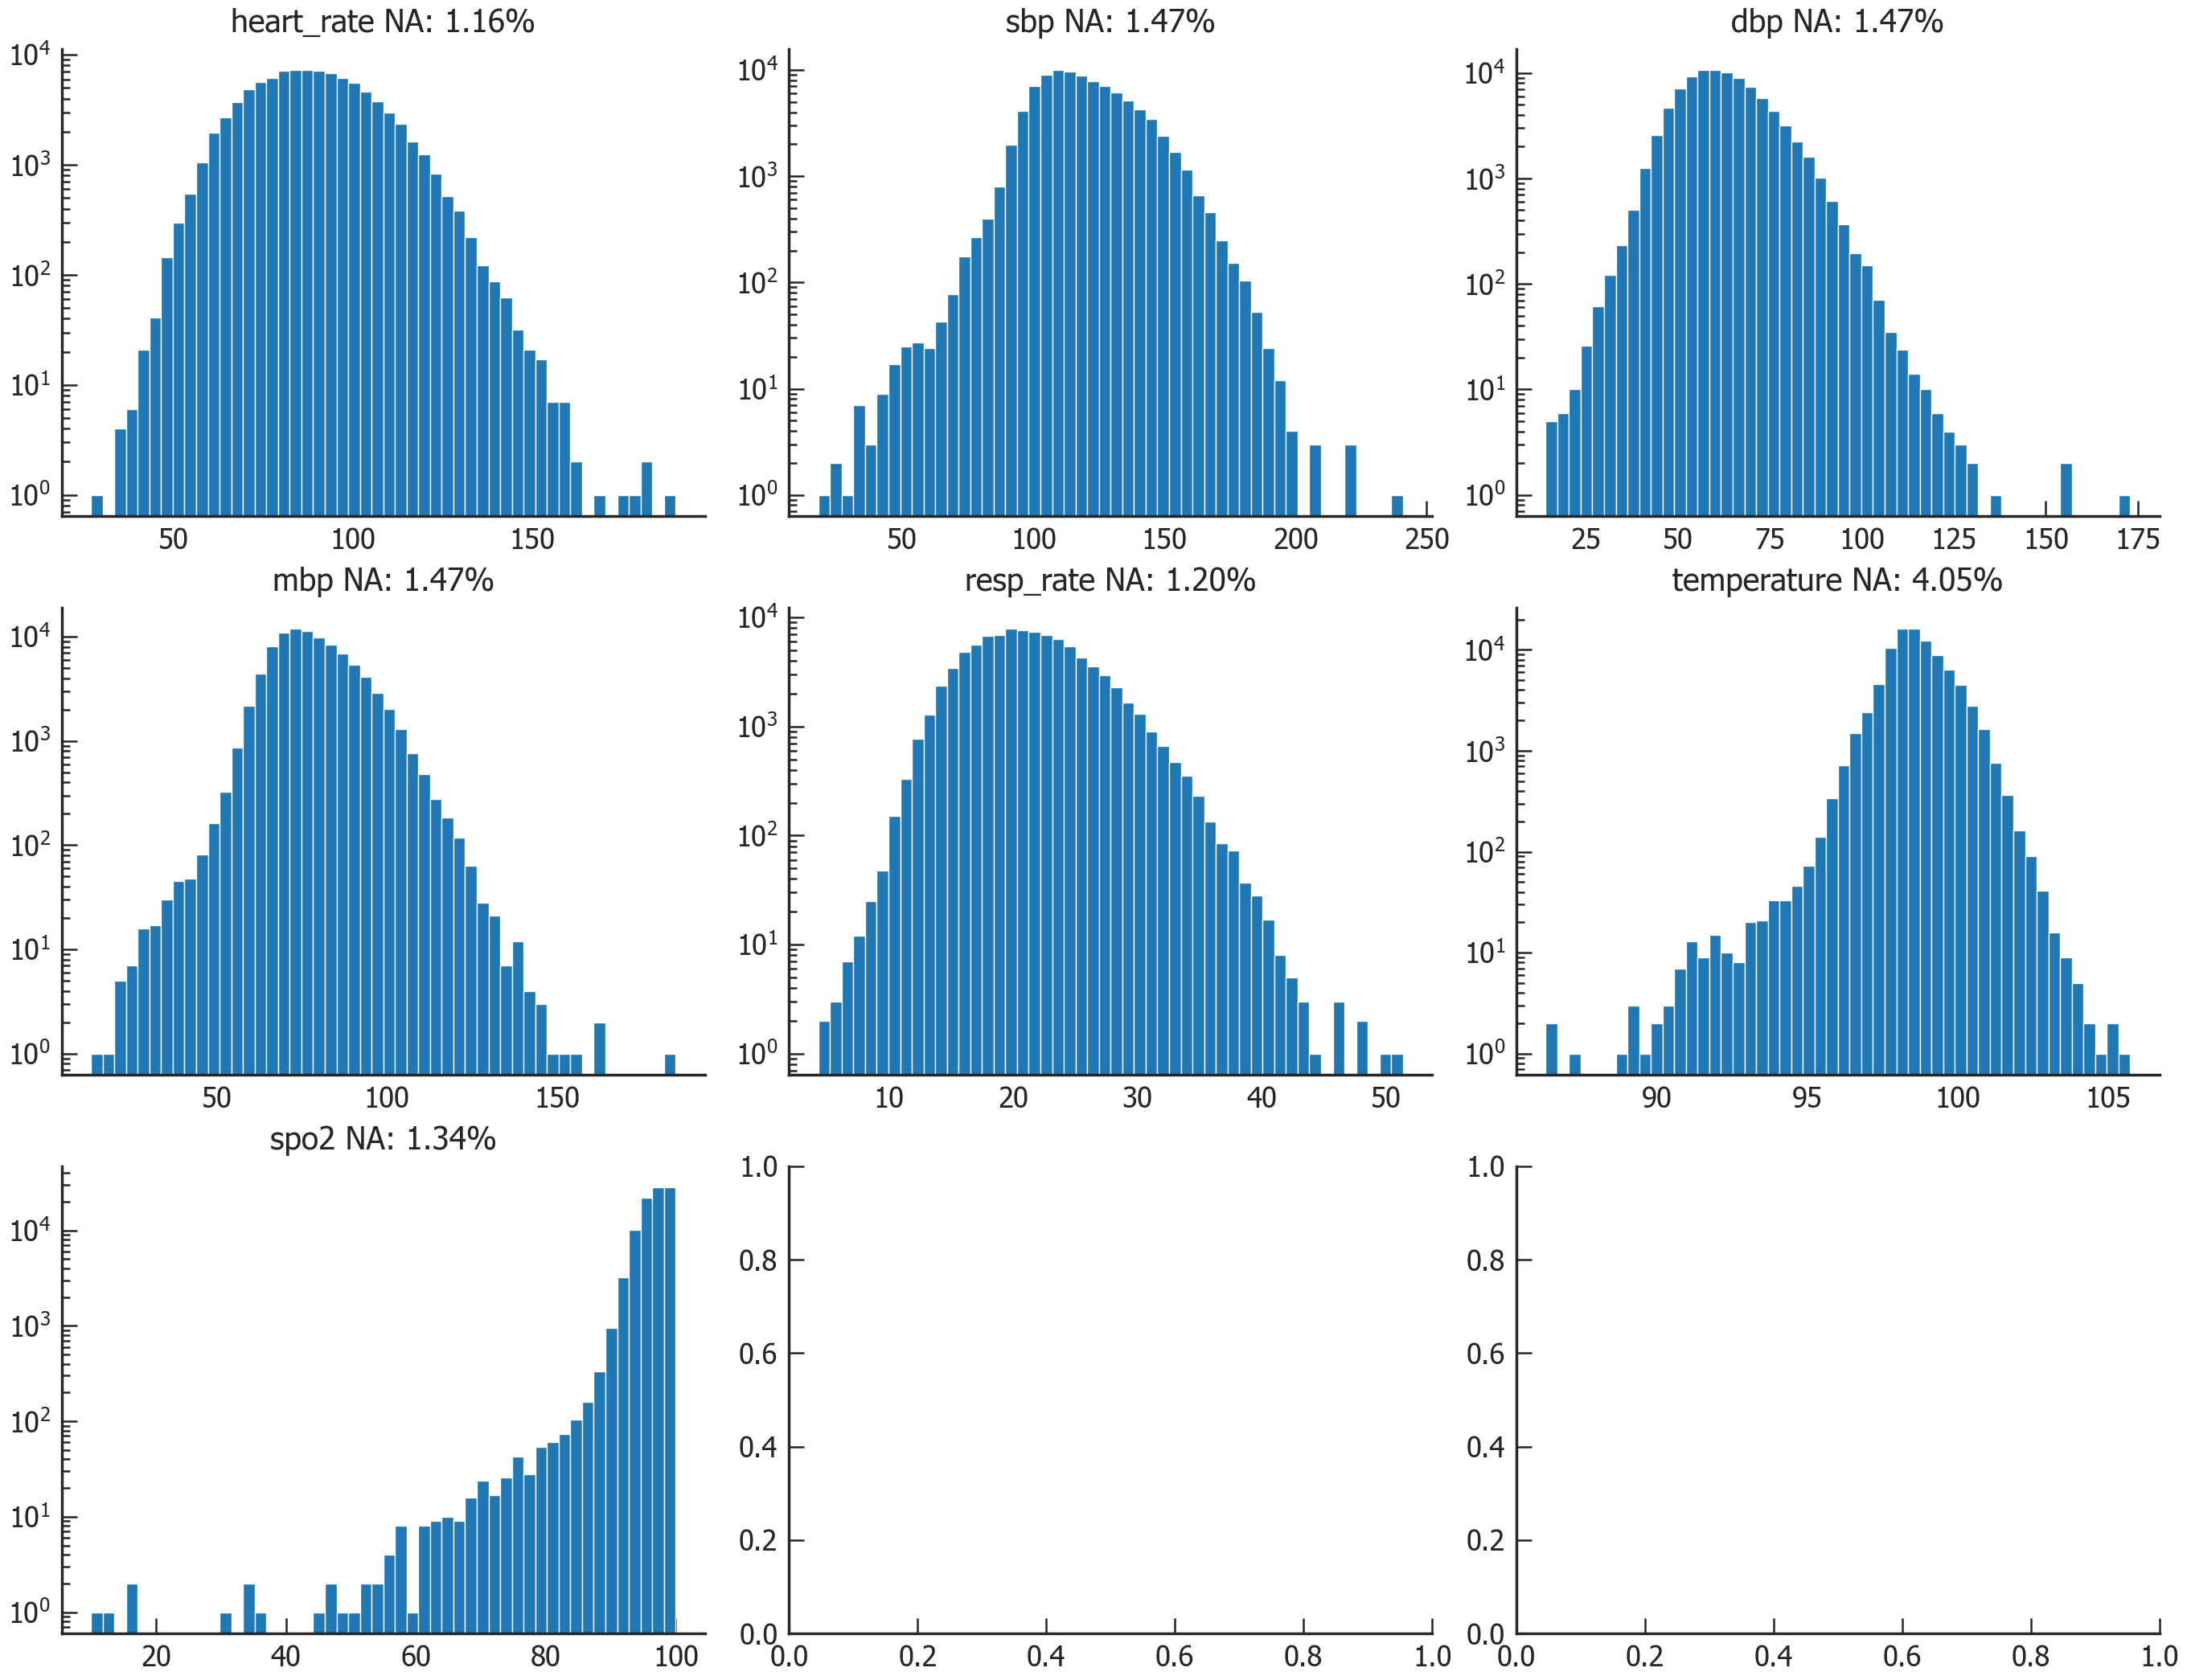

In [69]:
dsc_features = vitals.columns[3:]
cols = np.pad(np.array(dsc_features, dtype=object), (0, 9-len(dsc_features)), constant_values=np.nan).reshape(3, 3)
fig, axes = plt.subplots(
    nrows=cols.shape[0], 
    ncols=cols.shape[1], 
    figsize=plots.stdfigsize(nx=cols.shape[1], ny=cols.shape[0]),
)
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        column = cols[row, col]
        if isinstance(column, str):
            # bins = np.arange(0, sofa[column].max() + 1.5) - 0.5
            axes[row, col].hist(data[column], bins=50, log=True)
            axes[row, col].set_title(column+f' NA: {(data[column].isna().sum()/data.shape[0]):.2%}')
plt.tight_layout()
# plt.savefig("../plots/mimiciv/vitals_240307.png", dpi=150, transparent=True, bbox_inches='tight')

## blood gas

In [70]:
bg = pd.read_csv(os.path.join(derived_dir, 'bg.csv.gz'))

In [71]:
bg = bg.assign(icu_date=pd.to_datetime(bg.charttime).dt.date)

In [72]:
bg = bg.merge(data[['subject_id', 'icu_date']])

In [73]:
bg.specimen.value_counts(dropna=False)

specimen
ART.               124382
VEN.                20605
CENTRAL VENOUS.      2904
MIX.                 2748
NaN                  1642
Name: count, dtype: int64

In [74]:
abg = bg[bg.specimen=='ART.']

In [75]:
abg = abg.drop(columns=['hadm_id', 'charttime', 'specimen']).groupby(['subject_id', 'icu_date']).agg('mean')

In [76]:
abg = abg[['po2', 'pco2', 'ph', 'pao2fio2ratio', 'totalco2', 'lactate']].reset_index()

In [77]:
data = data.merge(abg, how='left')

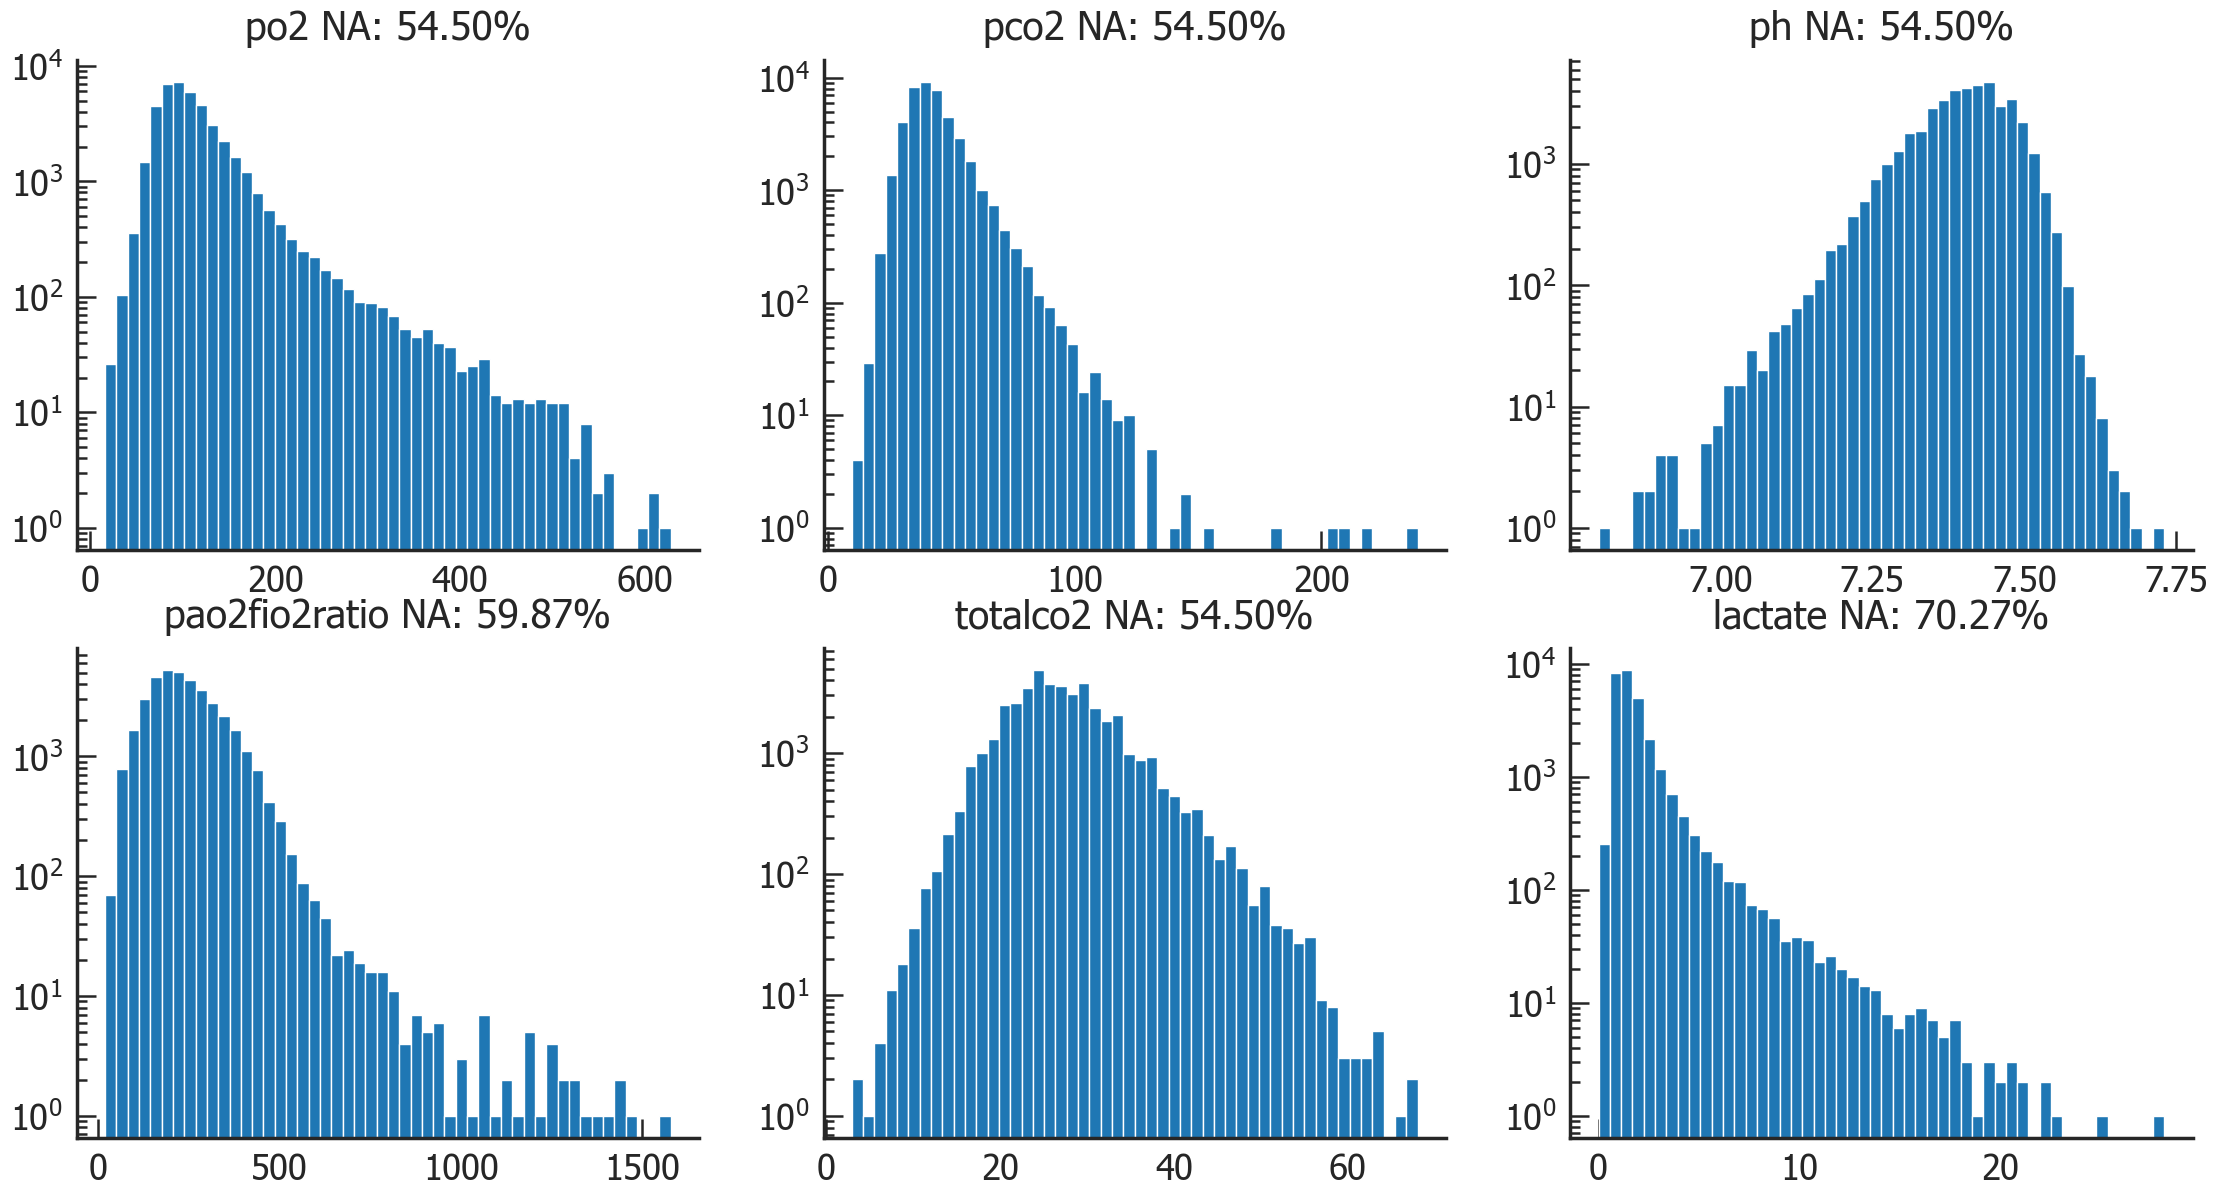

In [78]:
nc = 3
nr = 2
fig, axs = plt.subplots(nr, nc, figsize=plots.stdfigsize(nx=nc, ny=nr))

for i in range(6):
    cc = abg.columns[i+2]
    axs[i//nc, i%nc].hist(data[cc], bins=50, log=True)
    axs[i//nc, i%nc].set_title(cc+f' NA: {(data[cc].isna().sum()/data.shape[0]):.2%}')

# plt.savefig("../plots/mimiciv/abg_240307.png", dpi=150, transparent=True, bbox_inches='tight')

## blood differential

In [79]:
blood_differential = pd.read_csv(os.path.join(derived_dir, 'blood_differential.csv.gz'))

In [80]:
blood_differential = blood_differential.assign(icu_date=pd.to_datetime(blood_differential.charttime).dt.date)

In [81]:
bd = blood_differential.merge(data[['subject_id', 'icu_date']]).drop(\
    columns=['hadm_id', 'charttime', 'specimen_id']).groupby(['subject_id', 'icu_date']).agg('mean')

In [82]:
bd = bd.filter(regex='_abs|wbc$').reset_index()

In [83]:
data = data.merge(bd, how='left')

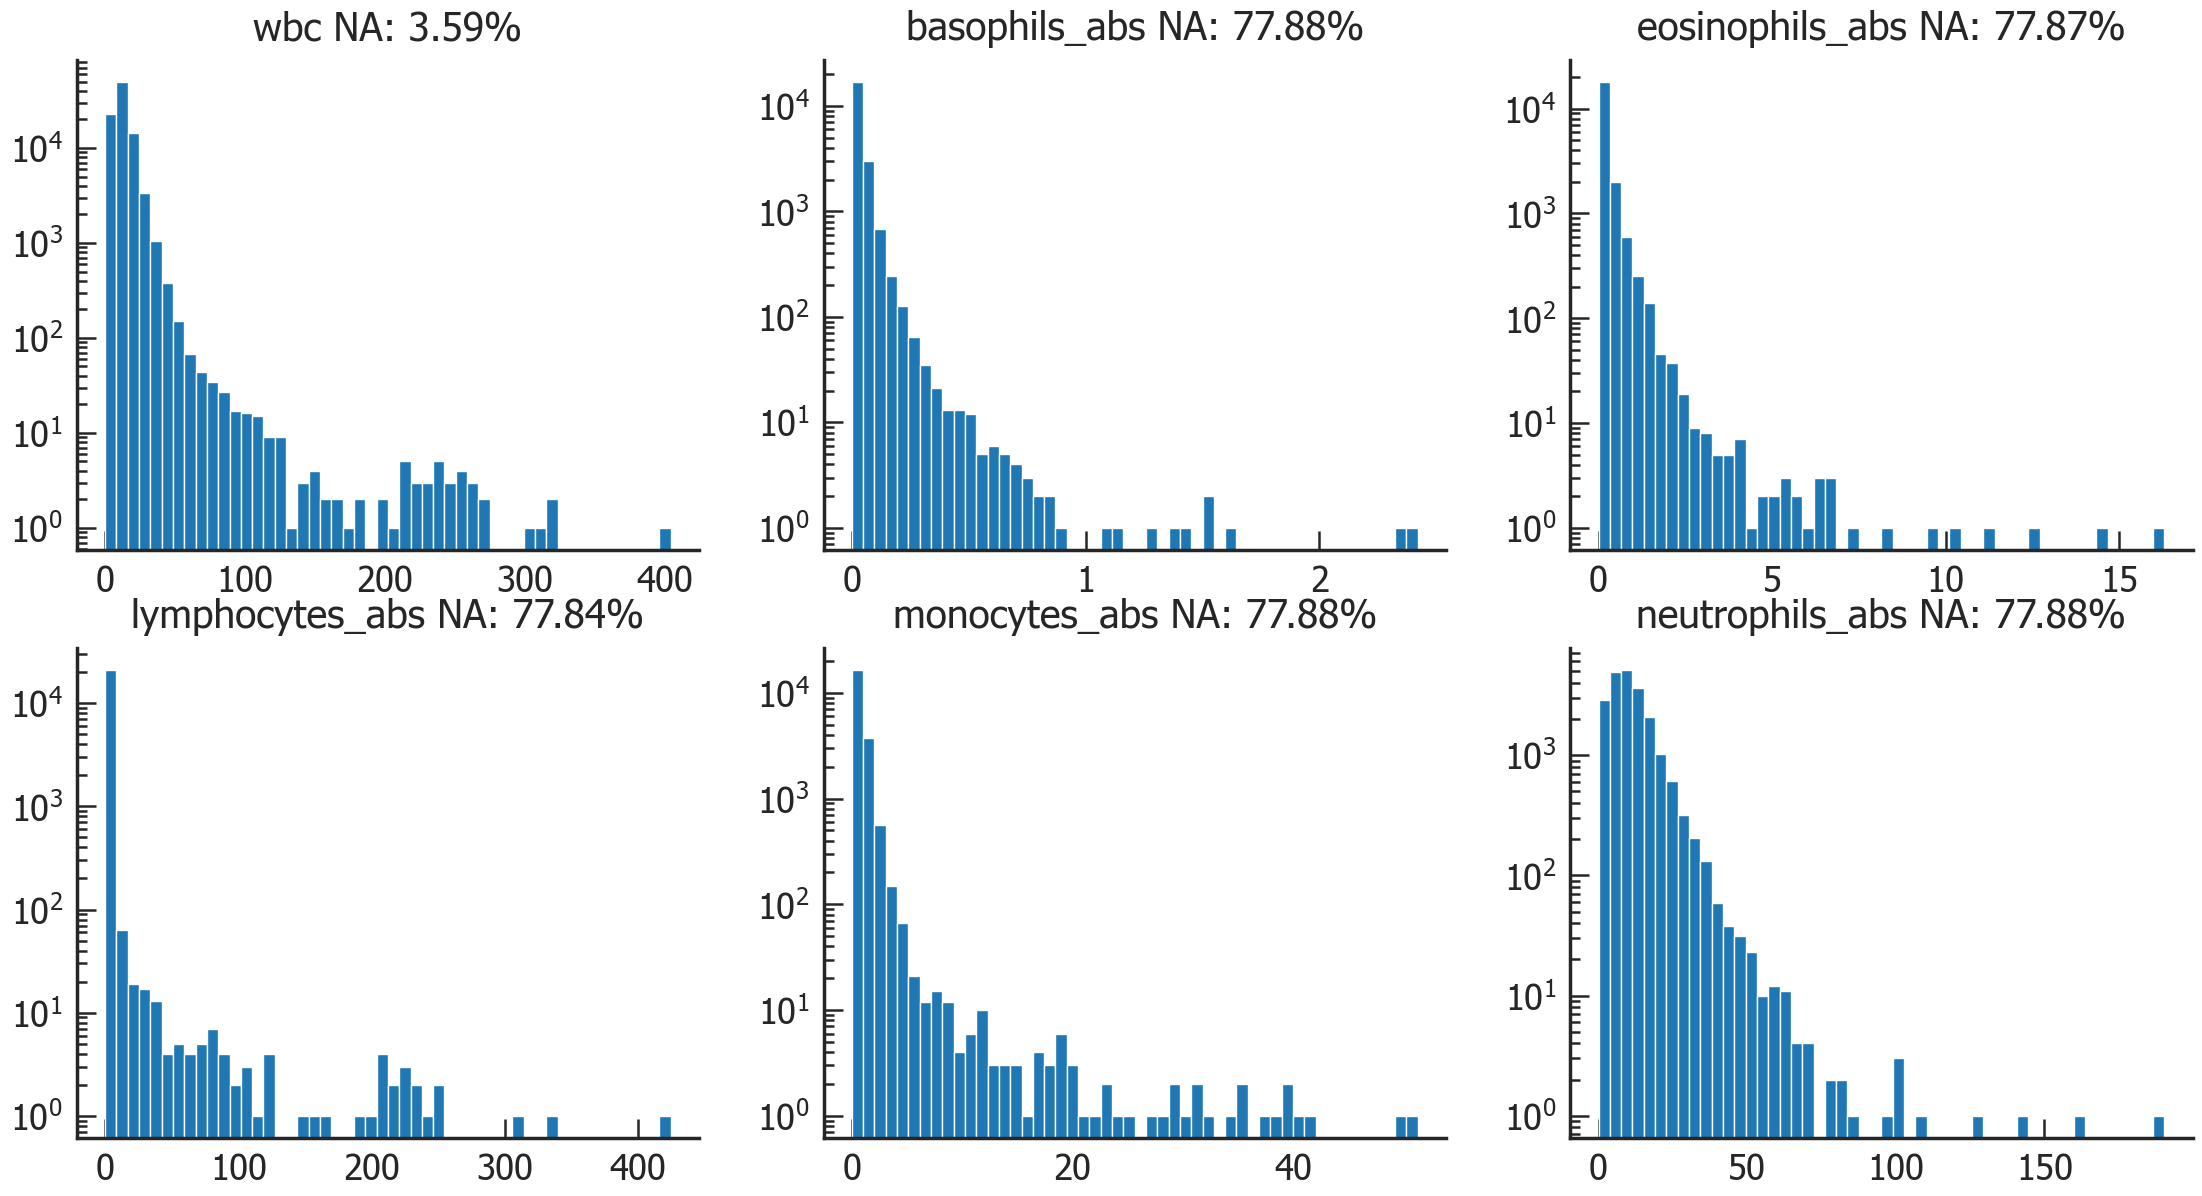

In [84]:
nc = 3
nr = 2
fig, axs = plt.subplots(nr, nc, figsize=plots.stdfigsize(nx=nc, ny=nr))

for i in range(6):
    cc = bd.columns[i+2]
    axs[i//3, i%3].hist(data[cc], bins=50, log=True)
    axs[i//3, i%3].set_title(cc+f' NA: {(data[cc].isna().sum()/data.shape[0]):.2%}')

# plt.savefig("../plots/mimiciv/blood_differential_240307.png", dpi=150, transparent=True, bbox_inches='tight')

## complete blood count

In [85]:
complete_blood_count = pd.read_csv(os.path.join(derived_dir, 'complete_blood_count.csv.gz'))

In [86]:
complete_blood_count = complete_blood_count.assign(icu_date=pd.to_datetime(complete_blood_count.charttime).dt.date)

In [87]:
cbc = complete_blood_count.merge(data[['subject_id', 'icu_date']]).drop(\
    columns=['hadm_id', 'charttime', 'specimen_id']).groupby(['subject_id', 'icu_date']).agg('mean')

In [88]:
cbc = cbc[['hemoglobin', 'hematocrit', 'mch', 'mchc', 'mcv', 'platelet', 'rbc', 'rdw']].reset_index()

In [89]:
data = data.merge(cbc, how='left')

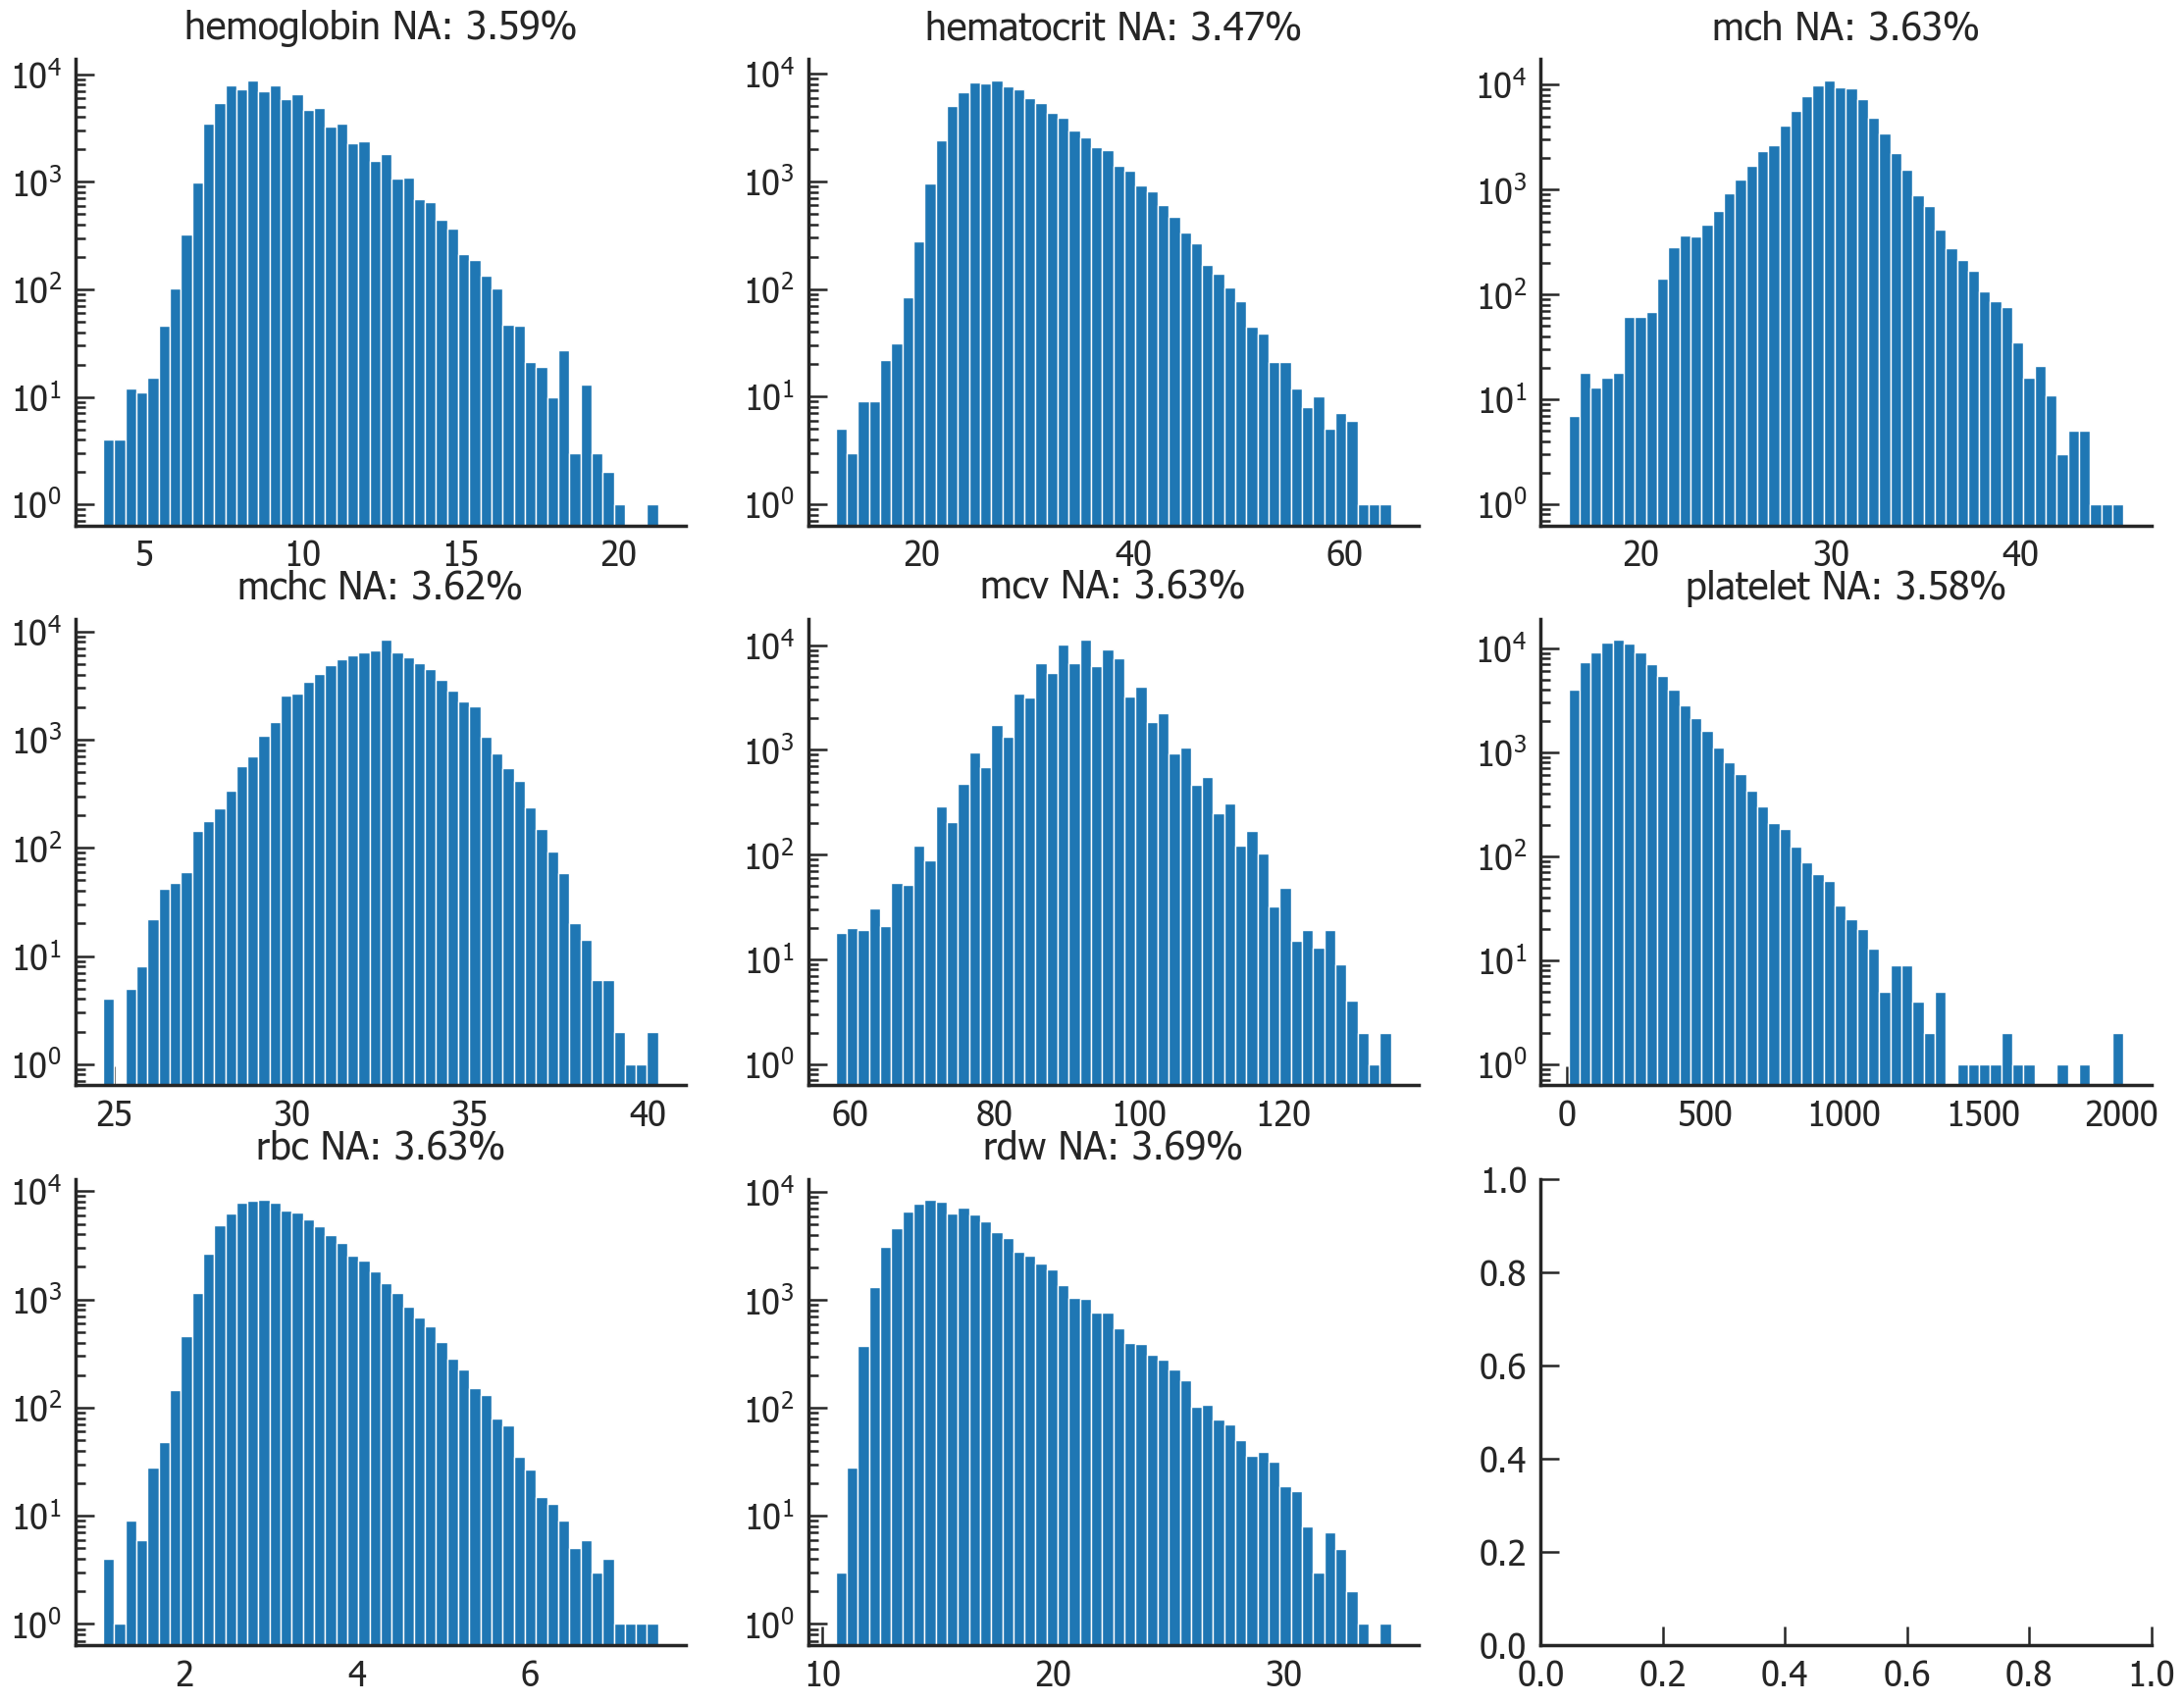

In [90]:
nc = 3
nr = 3
fig, axs = plt.subplots(nr, nc, figsize=plots.stdfigsize(nx=nc, ny=nr))

for i in range(8):
    cc = cbc.columns[i+2]
    axs[i//3, i%3].hist(data[cc], bins=50, log=True)
    axs[i//3, i%3].set_title(cc+f' NA: {(data[cc].isna().sum()/data.shape[0]):.2%}')

# plt.savefig("../plots/mimiciv/blood_differential_240307.png", dpi=150, transparent=True, bbox_inches='tight')

## chemistry

In [91]:
chemistry = pd.read_csv(os.path.join(derived_dir, 'chemistry.csv.gz'))

In [92]:
chemistry = chemistry.assign(icu_date=pd.to_datetime(chemistry.charttime).dt.date)

In [93]:
chemistry = chemistry.merge(data[['subject_id', 'icu_date']]).drop(\
    columns=['hadm_id', 'charttime', 'specimen_id']).groupby(['subject_id', 'icu_date']).agg('mean')

In [94]:
chemistry = chemistry.drop(columns=['globulin', 'total_protein']).reset_index()

In [95]:
data = data.merge(chemistry, how='left')

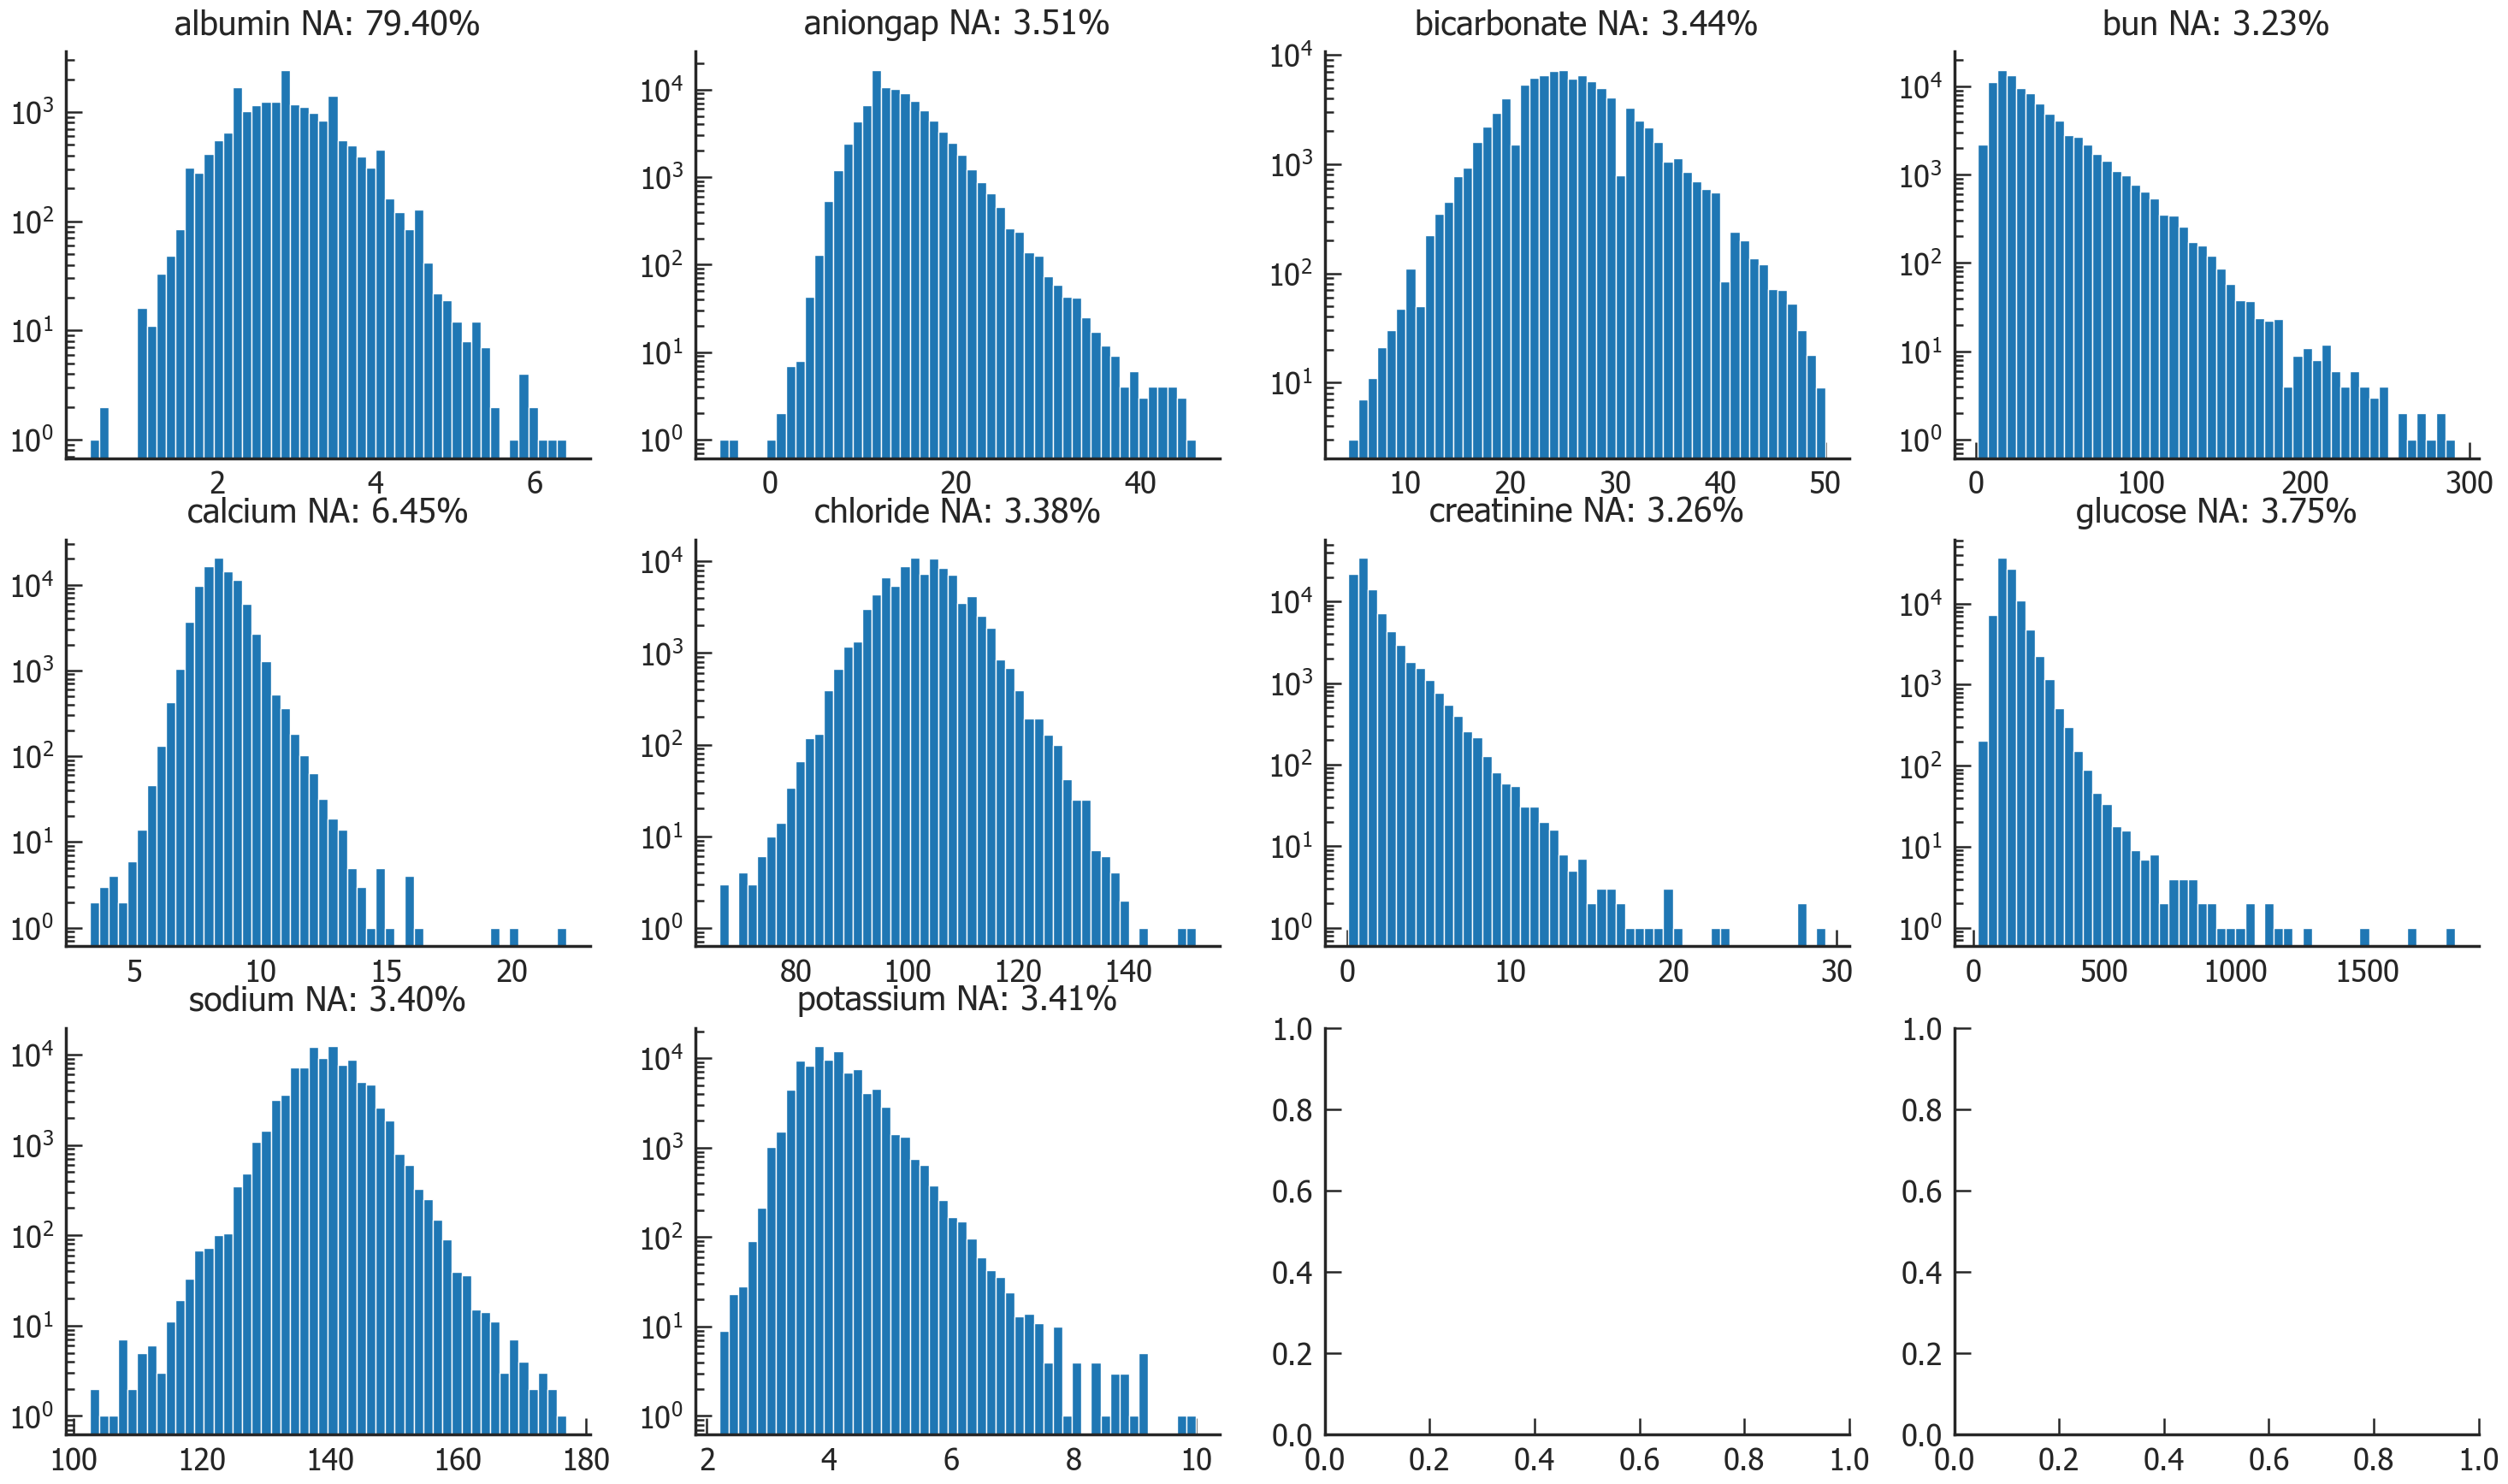

In [96]:
nc=4
nr=3
fig, axs = plt.subplots(nr,nc,figsize=plots.stdfigsize(nx=nc,ny=nr))

for i in range(10):
    cc = chemistry.columns[i+2]
    axs[i//nc, i%nc].hist(data[cc], bins=50, log=True)
    axs[i//nc, i%nc].set_title(cc+f' NA: {(data[cc].isna().sum()/data.shape[0]):.2%}')

# plt.savefig("../plots/mimiciv/chemistry_240308.png", dpi=150, transparent=True, bbox_inches='tight')

## enzyme

In [97]:
enzyme = pd.read_csv(os.path.join(derived_dir, 'enzyme.csv.gz'))

In [98]:
enzyme = enzyme.assign(icu_date=pd.to_datetime(enzyme.charttime).dt.date)

In [99]:
enzyme = enzyme.merge(data[['subject_id', 'icu_date']]).drop(\
    columns=['hadm_id', 'charttime', 'specimen_id']).groupby(['subject_id', 'icu_date']).agg('mean')

In [100]:
enzyme = enzyme[['bilirubin_total', 'alt', 'alp', 'ast', 'ld_ldh']].reset_index()

In [101]:
data = data.merge(enzyme, how='left')

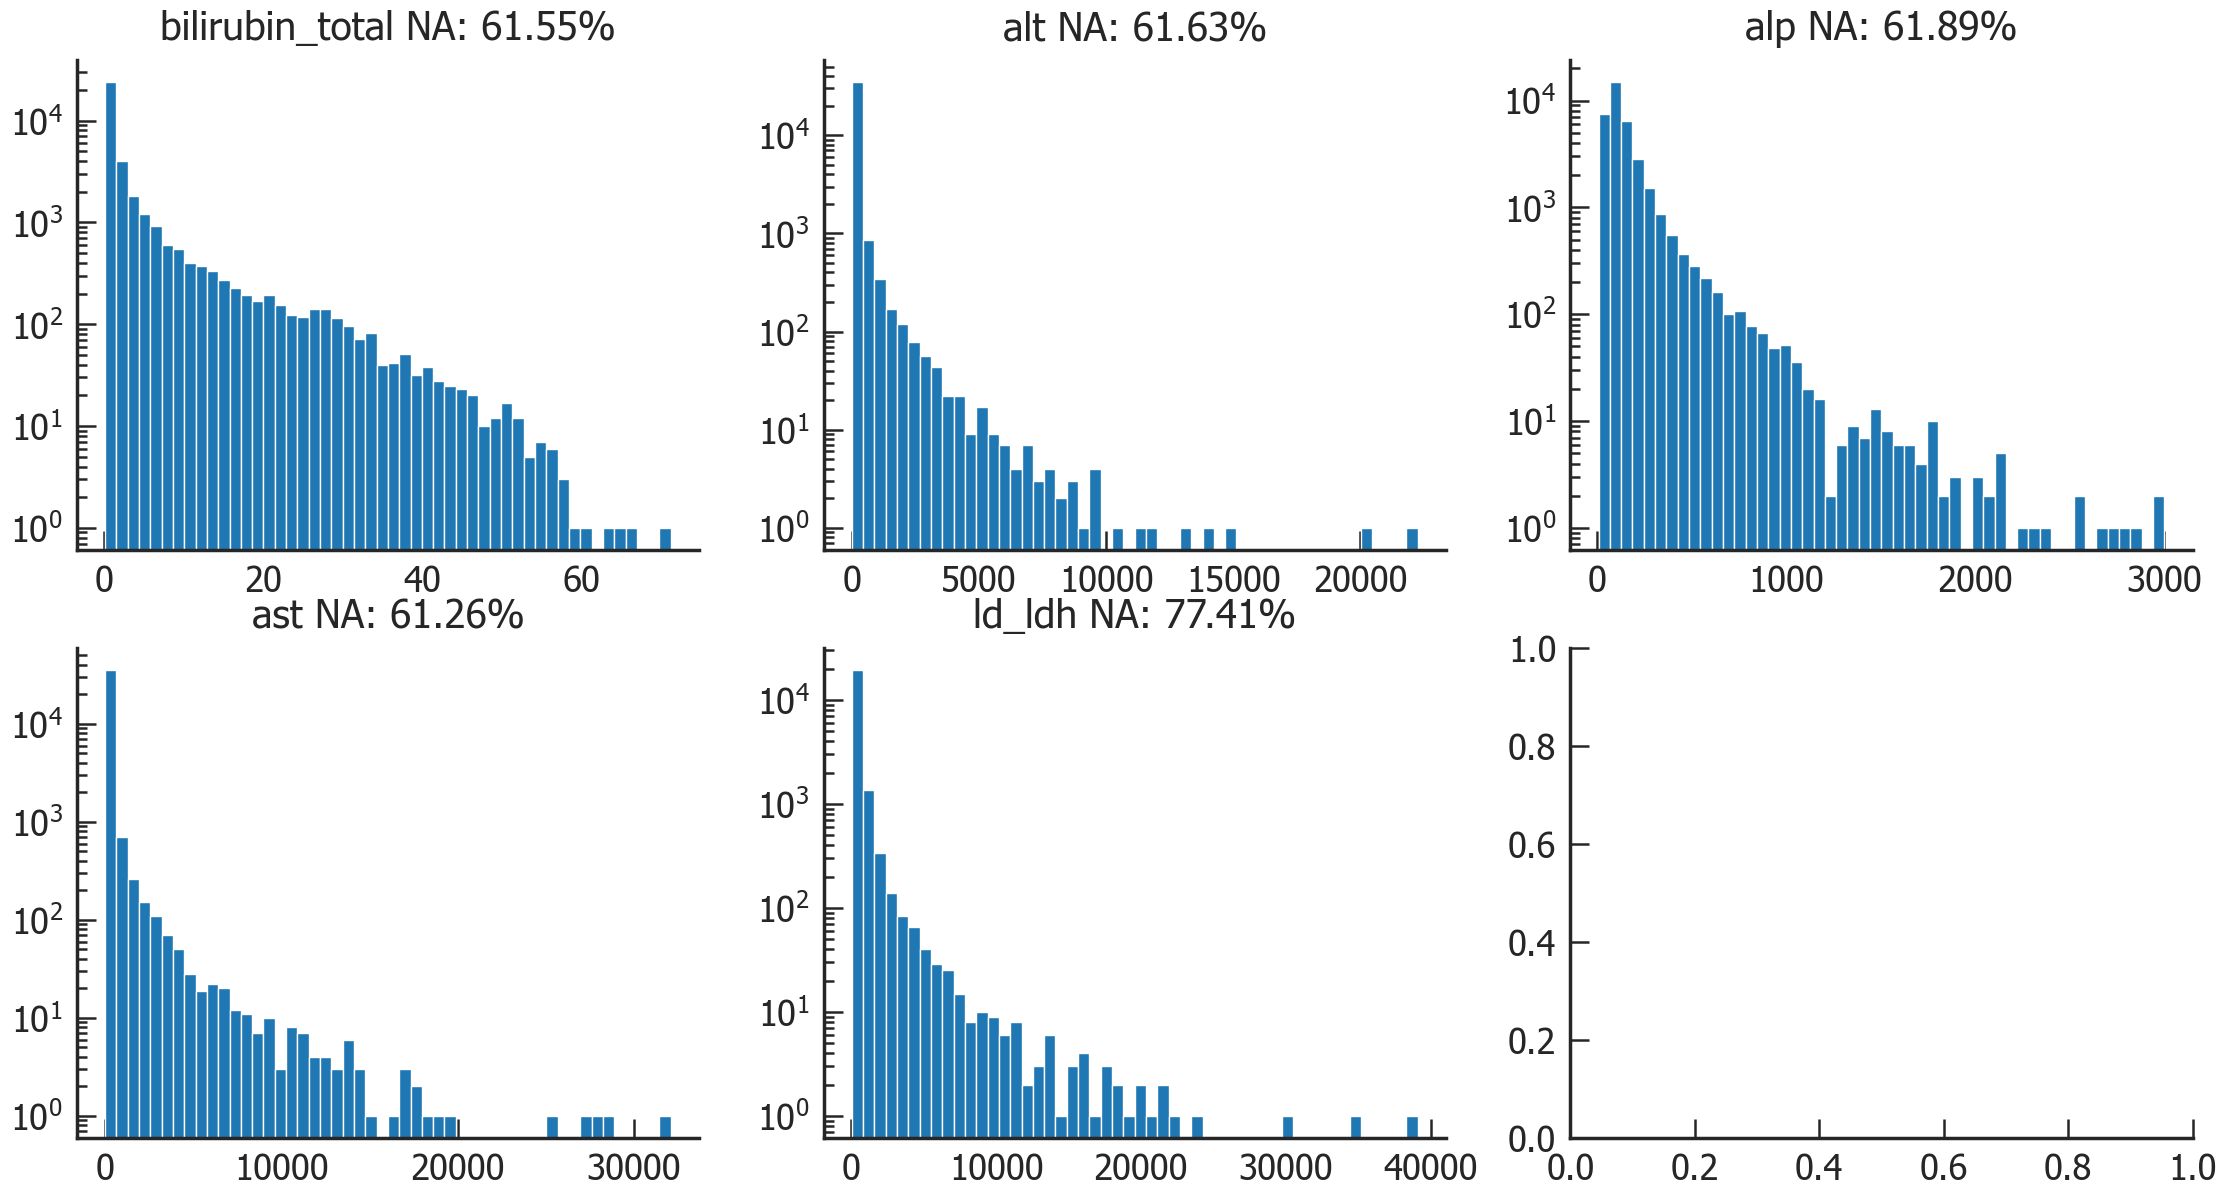

In [102]:
nc=3
nr=2
fig, axs = plt.subplots(nr,nc,figsize=plots.stdfigsize(nx=nc,ny=nr))

for i in range(5):
    cc = enzyme.columns[i+2]
    axs[i//nc, i%nc].hist(data[cc], bins=50, log=True)
    axs[i//nc, i%nc].set_title(cc+f' NA: {(data[cc].isna().sum()/data.shape[0]):.2%}')

# plt.savefig("../plots/mimiciv/enzyme_240308.png", dpi=150, transparent=True, bbox_inches='tight')

## inflammation -- crp

In [103]:
inflammation = pd.read_csv(os.path.join(derived_dir, 'inflammation.csv.gz'))

In [104]:
inflammation = inflammation.assign(icu_date=pd.to_datetime(inflammation.charttime).dt.date)

In [105]:
inflammation = inflammation.merge(data[['subject_id', 'icu_date']]).drop(\
    columns=['hadm_id', 'charttime', 'specimen_id']).groupby(['subject_id', 'icu_date']).agg('mean')

In [106]:
data = data.merge(inflammation.reset_index(), how='left')

Text(0.5, 1.0, 'CRP NA: 99.22%')

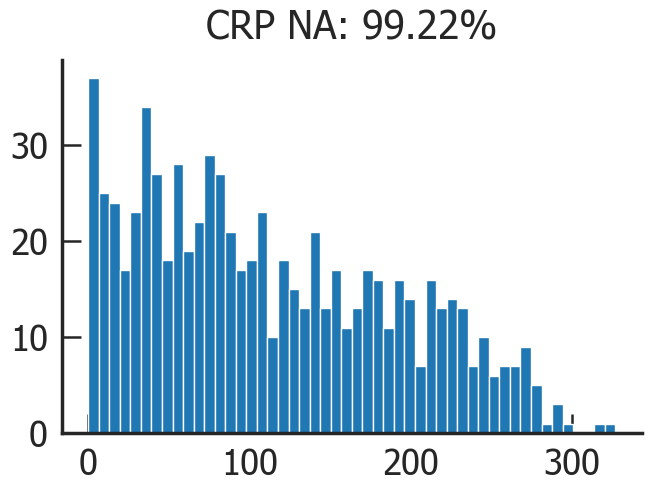

In [107]:
fig, ax = plt.subplots(constrained_layout=True)

ax.hist(data['crp'], bins=50, log=False)
ax.set_title('CRP'+f" NA: {(data['crp'].isna().sum()/data.shape[0]):.2%}")
# plt.savefig("../plots/mimiciv/CRP_240308.png", dpi=150, transparent=True, bbox_inches='tight')

## coagulation 

In [108]:
coagulation = pd.read_csv(os.path.join(derived_dir, 'coagulation.csv.gz'))

In [109]:
coagulation = coagulation.assign(icu_date=pd.to_datetime(coagulation.charttime).dt.date)

In [110]:
coagulation = coagulation.merge(data[['subject_id', 'icu_date']]).drop(\
    columns=['hadm_id', 'charttime', 'specimen_id']).groupby(['subject_id', 'icu_date']).agg('mean')

In [111]:
coagulation = coagulation[['d_dimer', 'inr', 'pt', 'ptt']].reset_index()

In [112]:
data = data.merge(coagulation, how='left')

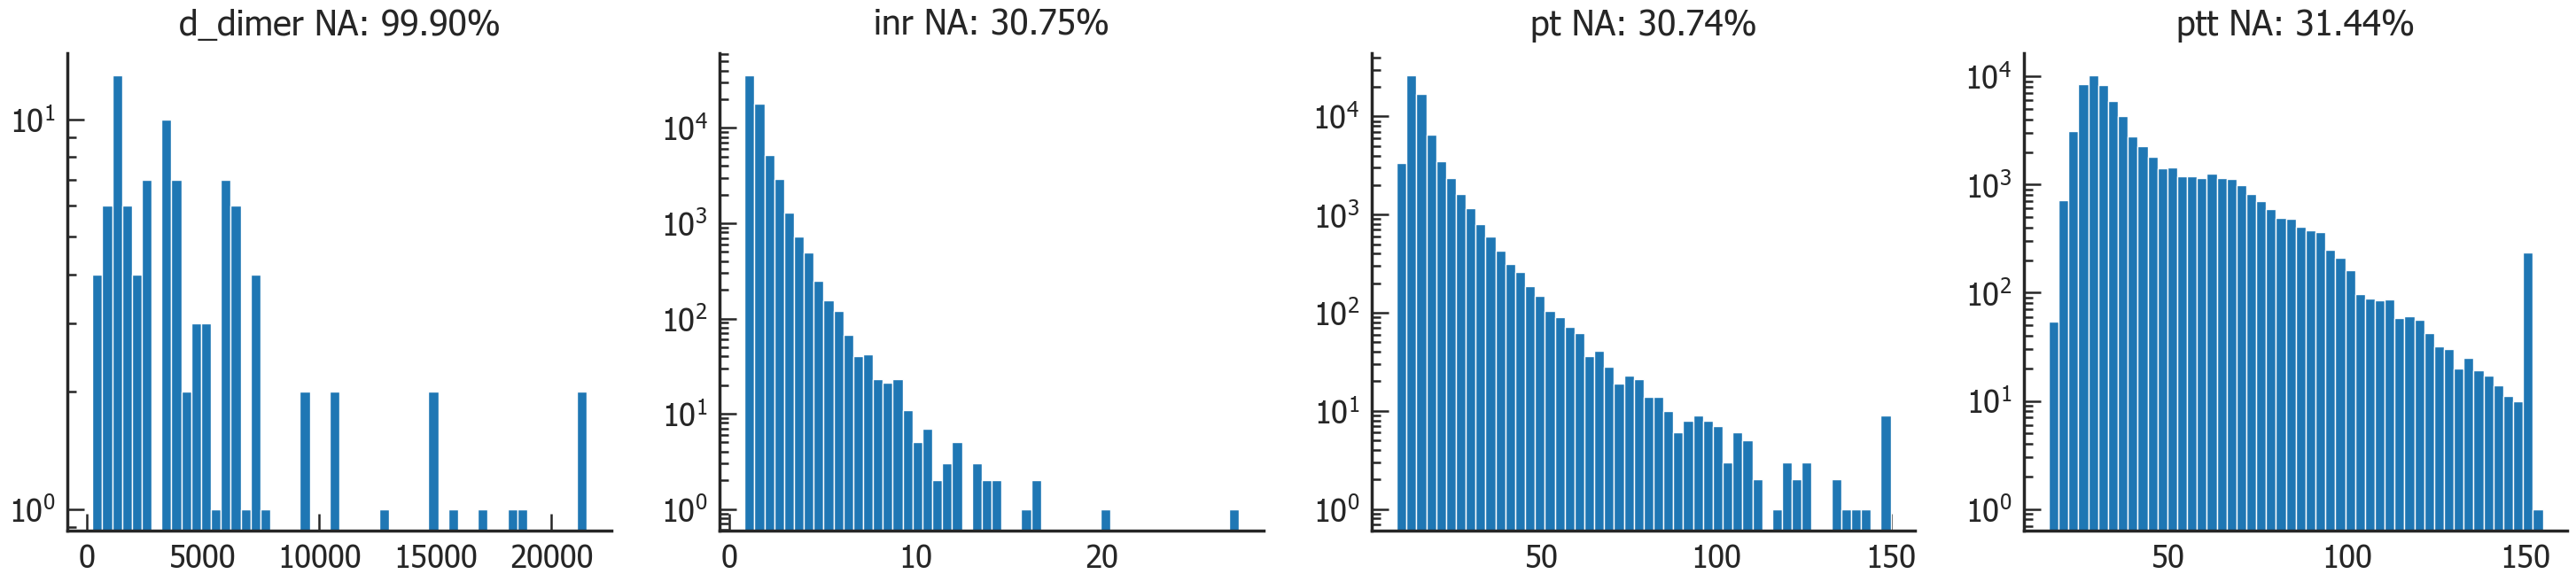

In [113]:
nc=4
nr=1
fig, axs = plt.subplots(nr,nc,figsize=plots.stdfigsize(nx=nc,ny=nr))

for i in range(4):
    cc = coagulation.columns[i+2]
    axs[i%nc].hist(coagulation[cc], bins=50, log=True)
    axs[i%nc].set_title(cc+f' NA: {(data[cc].isna().sum()/data.shape[0]):.2%}')

# plt.savefig("../plots/mimiciv/coagulation_240308.png", dpi=150, transparent=True, bbox_inches='tight')

## Other -- Ferritin

In [114]:
d_labitems = pd.read_csv(os.path.join(mimic_dir, 'hosp', 'd_labitems.csv.gz'))

In [115]:
d_labitems[d_labitems.label.str.contains('Ferritin', case=False, na=False)]

,itemid,label,fluid,category
122,50924,Ferritin,Blood,Chemistry


In [116]:
chunks = pd.read_csv(os.path.join(mimic_dir, 'hosp', "labevents.csv.gz"), chunksize=10**6, low_memory=False)

In [117]:
Ferritin = pd.DataFrame()
count=0
for i in chunks:
    i = i[i.itemid==50924] 
    Ferritin = pd.concat([Ferritin,i])
    if count%100==0:
        print(count)
    count+=1

0
100


In [118]:
Ferritin = Ferritin[['subject_id', 'specimen_id', 'charttime', 'valuenum', 'valueuom']].drop_duplicates()

In [119]:
Ferritin.valueuom.unique()

array(['ng/mL'], dtype=object)

In [120]:
Ferritin.specimen_id.duplicated().sum()

0

In [121]:
Ferritin = Ferritin[['subject_id', 'charttime', 'valuenum']].dropna()

In [122]:
Ferritin = Ferritin.assign(icu_date=pd.to_datetime(Ferritin.charttime).dt.date)

In [123]:
Ferritin = Ferritin.merge(data[['subject_id', 'icu_date']]).drop(\
    columns=['charttime']).groupby(['subject_id', 'icu_date']).agg('mean')

In [124]:
data = data.merge(Ferritin.reset_index().rename(columns={'valuenum': 'ferritin'}), how='left')

Text(0.5, 1.0, 'ferritin NA: 97.90%')

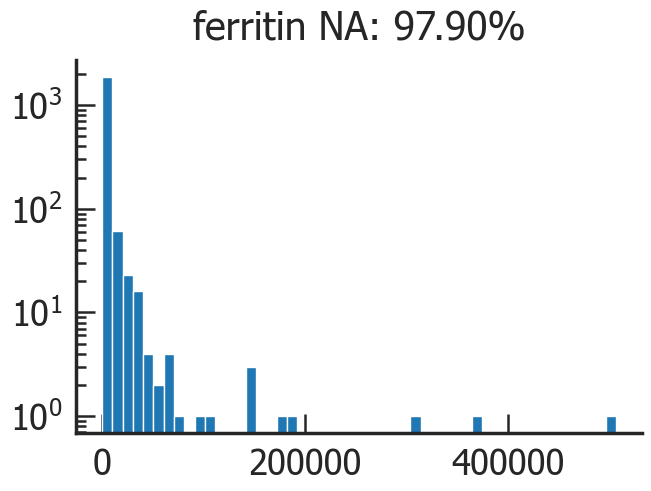

In [125]:
fig, ax = plt.subplots(constrained_layout=True)

ax.hist(data['ferritin'], bins=50, log=True)
ax.set_title('ferritin'+f" NA: {(data['ferritin'].isna().sum()/data.shape[0]):.2%}")
# plt.savefig("../plots/mimiciv/ferritin_240308.png", dpi=150, transparent=True, bbox_inches='tight')

## save

In [126]:
data.to_csv(os.path.join(included_dir, 'data.csv'))

In [127]:
edps.to_csv(os.path.join(curated_dir, 'mimic_edps.csv'))